In [1]:

import sys

sys.path.append("/nfs/nhome/live/aoomerjee/MSc-Thesis/")

import matplotlib.pyplot as plt
from pathlib import Path
from hct.io.model import load, save
import pandas as pd
import jax.numpy as jp
import jax
import importlib.util
import re
from typing import Literal
import seaborn as sns

def extract_date_time_from_log(log_file_path):
    """
    Extracts the date and time from the first line of the given log file.
    
    Args:
    - log_file_path (str): Path to the log file.

    Returns:
    - str: Date and time from the first log line, or None if not found.
    """
    with open(log_file_path, 'r') as file:
        first_line = file.readline()
        
        # Extract date and time using regex
        match = re.search(r'I(\d{2})(\d{2}) (\d{2}:\d{2}:\d{2}.\d{6})', first_line)
        if match:
            month, day, time = match.groups()
            date_str = f"{month}/{day} {time}"
            return date_str
    return None

def import_function_from_path(path, function_name):
    spec = importlib.util.spec_from_file_location("__temp_module__", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return getattr(module, function_name)


def get_training_metrics(modelpath):
    
    training_metrics = load(f"{modelpath}/training_metrics")
    training_metrics.pop('model_variant_name')

    training_steps = []
    metrics_per_training_step = []

    for k, v in training_metrics.items():
        training_steps.append(float(k))
        metrics_per_training_step.append(v)

    metrics_per_training_step[0].update(
      {'training/sps': 0.0, 
      'training/walltime': 0.0, 
      'training/entropy_loss': 0.0, 
      'training/policy_loss': 0.0, 
      'training/total_loss': 0.0, 
      'training/v_loss': 0.0
      }
    )

    return (training_steps, metrics_per_training_step)

def plot(data: tuple, 
         metric: str, 
         error: Literal[None, 'std', 'stderr'] = None, 
         label = None, 
         err_label = None, 
         xlabel = None, 
         ylabel = None,
         xlim = None,
         ylim = None,
         ax = None,
         linestyle = '-'
        ):
  
  
  steps, metrics = data
  max_steps = steps[-1]

  values = []
  lower_error = []
  upper_error = []
     
  
  for m in metrics:
    value = m[metric]['mean']
    if metric == 'eval/episode_distance_to_end':
       value = 22 - value
    err = m[metric][error]
    values.append(value)
    lower_error.append(value - err)
    upper_error.append(value + err)

  xlim = (0, max_steps) if xlim is None else xlim

  if ax == None:
     ax = plt
  
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

  if linestyle == '-':
    ax.plot(steps, values, linewidth=1, label=label)
  else:
    ax.plot(steps, values, linewidth=1, label=label, linestyle=linestyle, dashes = [5,5])  
  if error is not None:
    ax.fill_between(steps, lower_error , upper_error , alpha=0.1, label=err_label) 



pd.set_option('display.max_columns', None)



In [2]:


def generate_data_tables(hyperparam_sweeps):

    hma_filepath = hyperparam_sweeps / "hma"
    hurdles_filepath = hyperparam_sweeps / "hurdles"
    gaps_filepath = hyperparam_sweeps / "gaps"
    maze_filepath = hyperparam_sweeps / "maze"

    filepaths = [hma_filepath, hurdles_filepath, gaps_filepath, maze_filepath]

    data = []
    
    for i, filepath in enumerate(filepaths):

        environment_name = filepath.name
        if environment_name == 'hma':
            steps = 150_000_000
        else:
            steps = 50_000_000

        for j, model in enumerate(filepath.iterdir()):

            model_category = model.name

            if model.is_dir() and not (environment_name.startswith('__') or environment_name.startswith('.')):
                runs = model / 'runs'
                hyperparameter_sweep = import_function_from_path(model / 'run.py', 'hyperparameter_sweep')
                env_params, training_params = hyperparameter_sweep()
                
                for run in runs.iterdir():

                    model_variant = run.name

                    if (run / 'network').exists() and int(model_variant) < len(env_params):

                        date = extract_date_time_from_log(run / 'log.INFO')

                        training_metrics = load(f'{run}/training_metrics')
                        env = load(f'{run}/env')

                        env_params[int(model_variant)].pop('architecture_configs')

                        final_metrics = {'date':date, 'model': model_category, 'environment': environment_name, 'model_variant_id': model_variant, 'modelpath': run}
                        final_metrics.update(env_params[int(model_variant)])
                        if 'low_level_modelpath' in final_metrics.keys():
                            low_level_model_name = int(Path(final_metrics['low_level_modelpath']).name)
                            low_level_env_params, _ = import_function_from_path(Path(final_metrics['low_level_modelpath']).parent.parent / 'run.py', 'hyperparameter_sweep')()
                            final_metrics['low_level_modelpath'] = low_level_model_name
                            final_metrics['position_goals'] = low_level_env_params[low_level_model_name]['position_goals']
                            final_metrics['velocity_goals'] = low_level_env_params[low_level_model_name]['velocity_goals']
                            final_metrics['goal_dist'] = low_level_env_params[low_level_model_name]['goal_dist']
                            final_metrics['distance_reward'] = low_level_env_params[low_level_model_name]['distance_reward']
                            final_metrics['goal_importance'] = low_level_env_params[low_level_model_name]['goal_importance']
                            final_metrics['low_level_goal_repeat'] = env.action_repeat
                        elif 'mid_level_modelpath' in final_metrics.keys():
                            mid_level_model_name = int(Path(final_metrics['mid_level_modelpath']).name)
                            mid_level_env = env.mid_level_env
                            final_metrics['mid_level_modelpath'] = mid_level_model_name
                            final_metrics['position_goals'] = mid_level_env.position_goals
                            final_metrics['velocity_goals'] = mid_level_env.velocity_goals
                            final_metrics['goal_dist'] = mid_level_env.goal_dist
                            final_metrics['distance_reward'] = mid_level_env.distance_reward
                            final_metrics['goal_importance'] = mid_level_env.goal_importance_framework
                            final_metrics['low_level_goal_repeat'] = mid_level_env.action_repeat
                            final_metrics['mid_level_goal_repeat'] = env.action_repeat
                            final_metrics['no_root_goals'] = mid_level_env.no_root_goals

                        total_steps = list(map(int, list(training_metrics.keys())[1:]))
                        ind = jp.argmax(jp.array(total_steps) > steps)
                        
                        if ind == 0:
                            continue
                        
                        final_metrics.update(training_metrics[list(training_metrics.keys())[ind]])
                        final_metrics = {key: f"{value['mean']:.4f} ± {value['std']:.4f}" if isinstance(value, dict) else value for key, value in final_metrics.items()}

                        data.append(final_metrics)

    data = pd.DataFrame(data)
    data.sort_values(by=['model', 'environment', 'model_variant_id'], inplace=True, ascending=True)

    savepath = f"experimental_results.csv"
    data.to_csv(savepath, index=False)
    data.model_variant_id = data.model_variant_id.astype(int)

    return data

hyperparam_sweeps_v2 = Path("/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/training/hyperparam_sweeps_v2")
hyperparam_sweeps_v3 = Path("/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/training/hyperparam_sweeps_v3")
data = generate_data_tables(hyperparam_sweeps_v2)
data2 = generate_data_tables(hyperparam_sweeps_v3)


2023-09-10 02:37:46.532416: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
benchmark_task_data = data[(data.environment == 'gaps') | (data.environment == 'hurdles') | (data.environment == 'maze')].sort_values(by="model_variant_id")
baseline = pd.concat([data[(data.model == 'flat') & (data.reward_type == 'sparse')], data2[(data2.model == 'hma2') & (data2.reward_type == 'sparse') & (data2.action_repeat == 1.0)]])
baseline['plot_data'] = baseline['modelpath'].apply(lambda x: get_training_metrics(x))



In [4]:
data = generate_data_tables(hyperparam_sweeps_v3)
def get_benchmark_data(environment,  reward_type, task_information, sortby='eval/episode_obstacles_complete', ascending=False):
    if sortby == 'eval/episode_obstacles_complete' and environment == 'maze':
        sortby = 'eval/episode_distance_to_end'
        ascending = True
    elif sortby == 'eval/episode_distance_to_end' and environment != 'maze':
        sortby = 'eval/episode_obstacles_complete'
        ascending = False
    df = benchmark_task_data[(benchmark_task_data.environment == environment) & (benchmark_task_data.reward_type == reward_type) & (benchmark_task_data.task_information == task_information)].sort_values(sortby, ascending=ascending)
    return df
a = get_benchmark_data('maze', 'dense', True, 'action_repeat')
a[a.model == 'hma2'].head(50)


,date,model,environment,model_variant_id,modelpath,position_goals,velocity_goals,goal_dist,distance_reward,goal_importance,eval/walltime,training/sps,training/walltime,training/entropy_loss,training/policy_loss,training/total_loss,training/v_loss,eval/episode_cumulative_final_goal_dist,eval/episode_cumulative_return,eval/episode_goal_dist,eval/episode_goals_reached,eval/episode_is_unhealthy,eval/episode_reward,eval/episode_weight,eval/avg_episode_length,eval/epoch_eval_time,eval/sps,low_level_modelpath,action_repeat,no_root_goals,low_level_goal_repeat,reward_type,task_information,eval/episode_obstacles_complete,eval/episode_task_complete,reward_movement,mid_level_modelpath,mid_level_goal_repeat,eval/episode_distance_to_end,eval/episode_maze_column,eval/episode_maze_row
206,08/28 17:48:34.400330,hma2,maze,19,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,continuous,123.219016,32070.481270,1454.971177,-0.3532197,-0.0055520767,4501.221,4501.58,NaN,NaN,NaN,NaN,0.1797 ± 0.3839,312.3043 ± 57.5230,NaN,1389.2188 ± 295.2108,13.070621,14689.431573,1.0,20.0,NaN,20.0,dense,True,NaN,0.0000 ± 0.0000,velocity,NaN,NaN,17.3828 ± 0.9852,4.0234 ± 0.5791,1.2188 ± 0.6366
218,08/26 18:31:51.782620,hma2,maze,3,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,None,121.960914,31742.114280,1460.785584,-0.34088805,-0.018065108,16947.088,16947.447,NaN,NaN,NaN,NaN,0.1797 ± 0.3839,426.1011 ± 109.3735,NaN,1364.8438 ± 335.7617,12.944895,14832.101733,0.0,20.0,NaN,20.0,dense,True,NaN,0.0000 ± 0.0000,velocity,NaN,NaN,15.3984 ± 2.0628,3.7188 ± 0.6242,2.2109 ± 0.9070
224,08/26 22:32:41.408944,hma2,maze,35,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,discrete,137.537452,20452.013547,2267.662013,-0.39759326,-0.011648245,4582.924,4583.333,NaN,NaN,NaN,NaN,0.3125 ± 0.4635,300.5280 ± 66.8377,NaN,1232.6562 ± 463.3902,14.855914,12924.145591,2.0,20.0,NaN,20.0,dense,True,NaN,0.0000 ± 0.0000,velocity,NaN,NaN,17.5703 ± 1.1088,4.2031 ± 0.5500,1.2734 ± 0.7778
208,08/28 17:48:34.400860,hma2,maze,18,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,continuous,226.952259,31544.393953,1580.528215,-0.28772974,-0.009166702,3336.9695,3337.2664,NaN,NaN,NaN,NaN,0.2812 ± 0.4496,472.0570 ± 95.2488,NaN,1323.7500 ± 344.8165,12.884924,14901.135421,1.0,10.0,NaN,10.0,dense,True,NaN,0.0000 ± 0.0000,velocity,NaN,NaN,14.4922 ± 1.8666,3.6406 ± 0.5960,2.6328 ± 0.8185
207,08/26 18:28:39.924451,hma2,maze,2,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,None,225.778933,32151.785325,1585.528925,-0.28833014,-0.009818524,15816.681,15816.979,NaN,NaN,NaN,NaN,0.2188 ± 0.4134,790.6158 ± 210.6363,NaN,1330.9375 ± 361.0606,12.974855,14797.853294,0.0,10.0,NaN,10.0,dense,True,NaN,0.0000 ± 0.0000,velocity,NaN,NaN,8.3359 ± 3.9947,2.1328 ± 1.2014,4.0938 ± 1.0416
223,08/26 22:17:14.739413,hma2,maze,34,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,discrete,226.192716,31630.255231,1576.959627,-0.36783916,-0.015107773,11832.326,11832.709,NaN,NaN,NaN,NaN,0.3203 ± 0.4666,558.5153 ± 187.4732,NaN,1226.5625 ± 477.3076,13.006880,14761.418792,2.0,10.0,NaN,10.0,dense,True,NaN,0.0000 ± 0.0000,velocity,NaN,NaN,12.8438 ± 3.2269,3.8281 ± 0.6387,3.8281 ± 1.0761
222,08/26 22:12:00.381933,hma2,maze,33,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,discrete,419.882724,100480.076370,514.231750,-0.37767807,-0.00647508,8250.613,8250.998,NaN,NaN,NaN,NaN,0.2422 ± 0.4284,1079.7964 ± 290.8592,NaN,1165.3516 ± 354.0514,12.935776,14842.557029,2.0,5.0,NaN,5.0,dense,True,NaN,0.6406 ± 0.4798,velocity,NaN,NaN,2.8359 ± 5.4195,1.4453 ± 1.0518,1.7656 ± 1.2342
204,08/28 17:48:51.259177,hma2,maze,17,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,continuous,481.677287,19862.595443,2504.515366,-0.3365333,-0.008420641,3096.4941,3096.8389,NaN,NaN,NaN,NaN,0.1406 ± 0.3476,894.3782 ± 154.6172,NaN,1416.6016 ± 257.4248,1

## HMA2 Performance

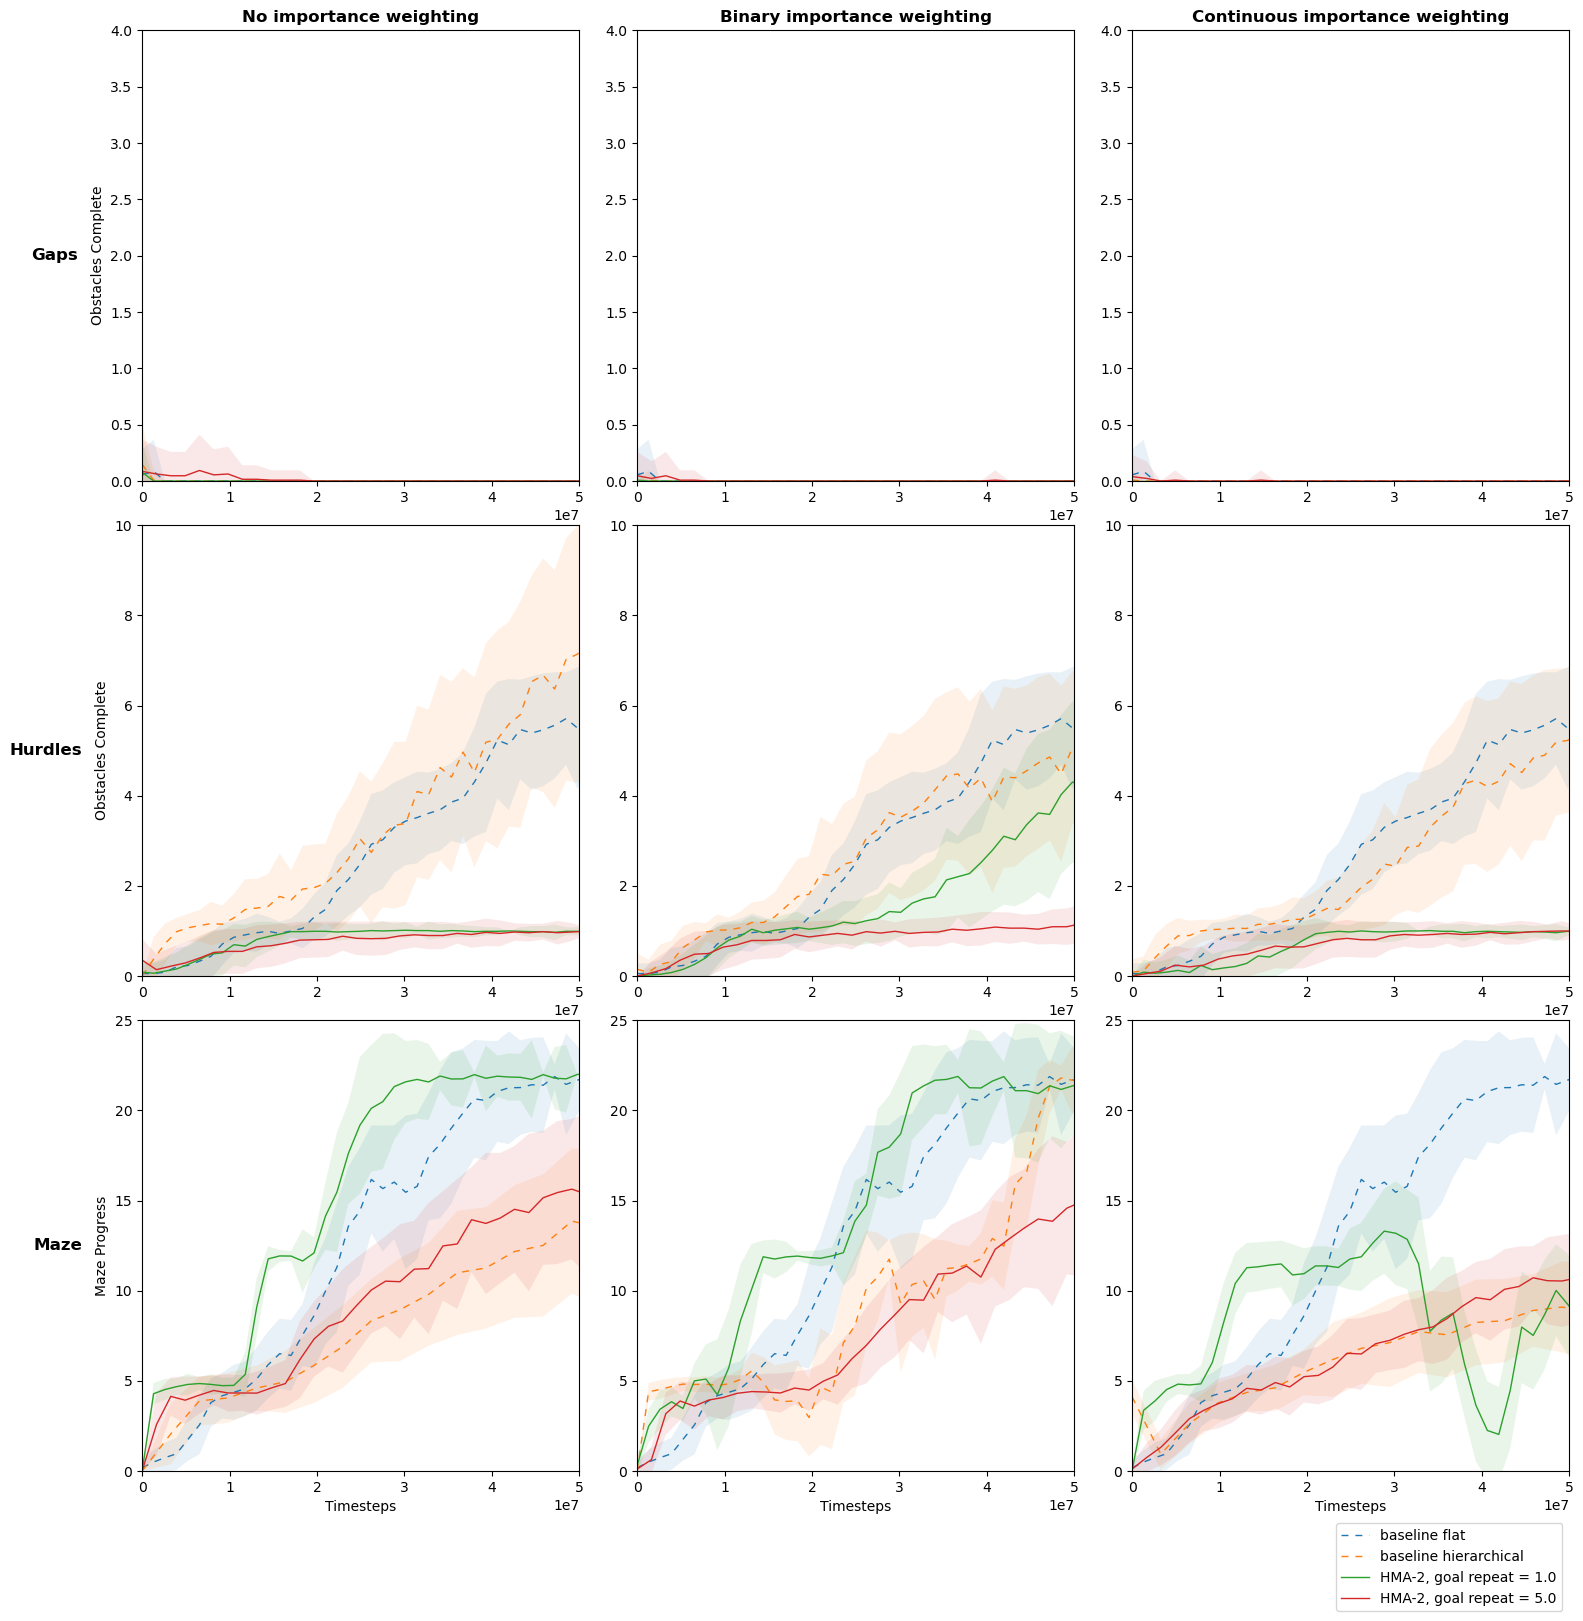

In [5]:
goal_importance_vals = [None, 'discrete', 'continuous']
action_repeats = [1.0, 5.0]
reward_types = ['sparse']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

plt.tight_layout()

for k, environment in enumerate(benchmark_task_data['environment'].unique()):

    if environment == 'maze':
        metric = 'eval/episode_distance_to_end'
        ylim = (0, 25)  
        ylabel = 'Maze Progress'
    else:
        metric = 'eval/episode_obstacles_complete'
        ylabel = 'Obstacles Complete'
        if environment == 'gaps':
            ylim = (0, 4)
        else:
            ylim = (0, 10)

    #metric = 'eval/episode_reward'

    for i, reward_type in enumerate(reward_types):
        
        df = get_benchmark_data(environment, reward_type, True)
        df = df[df.model != 'hma3'] 
        df['plot_data'] = df['modelpath'].apply(lambda x: get_training_metrics(x))

        flat = baseline[(baseline.model == 'flat') & (baseline.environment == environment)]
        hier = baseline[(baseline.model == 'hma2') & (baseline.environment == environment)]
        hma2 = df[df.model == 'hma2']

        for j, goal_importance in enumerate(goal_importance_vals):

            if goal_importance is None:
                t = 'No importance weighting'
            elif goal_importance == 'discrete':
                t = 'Binary importance weighting'
            else:
                t = 'Continuous importance weighting'
            ax = axs[k, j]
            ax.set_title(t if k==0 else None, weight='bold')

            if j == 0:
                ax.annotate(environment.capitalize(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation='horizontal', weight='bold')

            if pd.isna(goal_importance):
                ax_data = hma2[hma2.goal_importance.isna()]
                hier_data = hier[hier.goal_importance.isna()]
            else:
                ax_data = hma2[hma2.goal_importance == goal_importance]
                hier_data = hier[hier.goal_importance == goal_importance]
                        
            plot(
                data=flat.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline flat", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = (0,10),
                ax = ax,
                linestyle= '--'
                )
            
            plot(
                data=hier_data.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline hierarchical", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = (0,10),
                ax = ax,
                linestyle= '--'
                )
            
            for action_repeat in action_repeats:
                try:
                    plot_data = ax_data[ax_data.action_repeat == action_repeat]['plot_data'].iloc[0]
                except:
                    continue

                plot(
                    data=plot_data, 
                    metric=metric, 
                    error='std', 
                    label=f"HMA-2, goal repeat = {action_repeat}", 
                    err_label = None, 
                    xlabel = 'Timesteps' if k==2 else None, 
                    ylabel = ylabel if j==0 else None,
                    xlim = (0, 50_000_000),
                    ylim = ylim,
                    ax = ax
                    )
                
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.1))
plt.savefig('hma2.png')



        
            

IndexError: single positional indexer is out-of-bounds

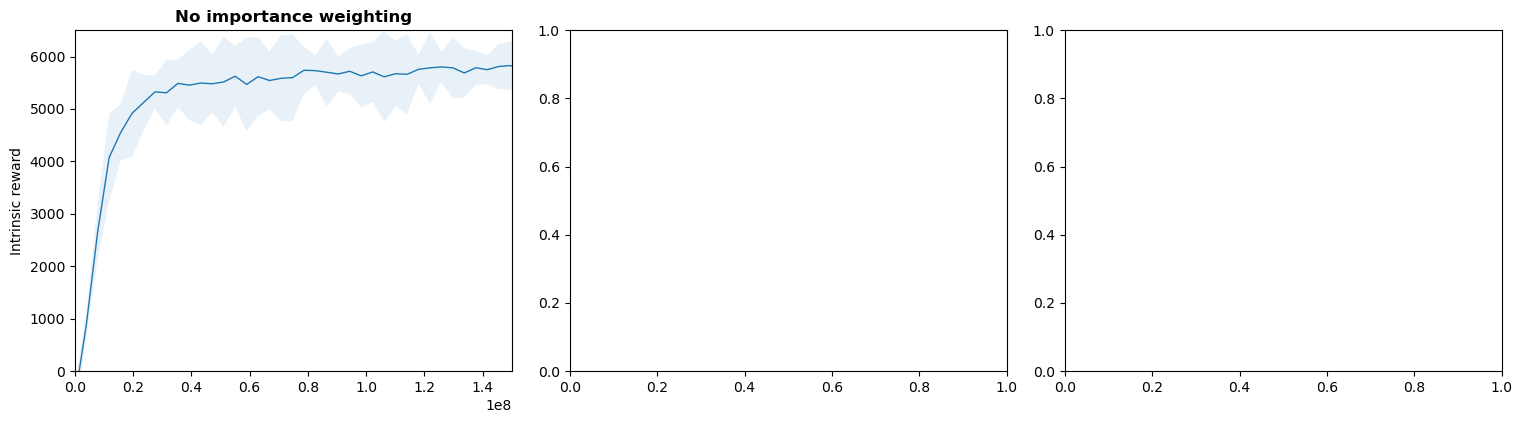

In [6]:
goal_importance_vals = [None, 'discrete', 'continuous']
action_repeats = [1.0, 5.0]
reward_types = ['dense', 'sparse']
model = 'mid_level'
mid_level_data = data[data.model == 'mid_level']


fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plt.tight_layout()

for i, no_root_goals in enumerate([False]):

 
    df = mid_level_data[mid_level_data['no_root_goals'] == no_root_goals]
    df['plot_data'] = df['modelpath'].apply(lambda x: get_training_metrics(x))

    for j, goal_importance in enumerate(goal_importance_vals):

        if goal_importance is None:
            t = 'No importance weighting'
        elif goal_importance == 'discrete':
            t = 'Binary importance weighting'
        else:
            t = 'Continuous importance weighting'
            
        ax = axs[j]
        ax.set_title(t if i==0 else None, weight='bold')

        if pd.isna(goal_importance):
            ax_data = df[df.goal_importance.isna()]
        else:
            ax_data = df[df.goal_importance == goal_importance]
    
        
        for action_repeat in action_repeats:
            
            plot_data = ax_data[ax_data.action_repeat == action_repeat]['plot_data'].iloc[0]

            plot(
                data=plot_data, 
                metric='eval/episode_reward', 
                error='std', 
                label=f"Mid level skill policy, low level goal repeat = {action_repeat}", 
                err_label = None, 
                xlabel = 'Timesteps' if i==1 else None, 
                ylabel = 'Intrinsic reward' if j==0 else None,
                xlim = (0, 150_000_000),
                ylim = (0, 6500),
                ax = ax
                )
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.1))


In [ ]:
mid_level_data[(mid_level_data.no_root_goals == False) & (mid_level_data.action_repeat == 1.0)].head(50)

,date,model,environment,model_variant_id,modelpath,position_goals,velocity_goals,goal_dist,distance_reward,goal_importance,eval/walltime,training/sps,training/walltime,training/entropy_loss,training/policy_loss,training/total_loss,training/v_loss,eval/episode_cumulative_final_goal_dist,eval/episode_cumulative_return,eval/episode_goal_dist,eval/episode_goals_reached,eval/episode_is_unhealthy,eval/episode_reward,eval/episode_weight,eval/avg_episode_length,eval/epoch_eval_time,eval/sps,state_below,low_level_modelpath,action_repeat,no_root_goals,low_level_goal_repeat,reward_type,task_information,eval/episode_obstacles_complete,eval/episode_task_complete,reward_movement,state,mid_level_modelpath,mid_level_goal_repeat,eval/episode_distance_to_end,eval/episode_maze_column,eval/episode_maze_row
6,08/31 18:48:24.664690,mid_level,hma,0,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,absolute,relative,None,1195.966500,89588.246489,1677.454419,-0.37021548,-0.008800148,3854.1975,3854.5762,58.557686,1656.852905,4.4557 ± 1.5463,0.0000 ± 0.0000,0.0078 ± 0.0880,5827.7983 ± 454.3091,12347.0,3480.2812 ± 222.2190,30.214665,14827.236953,True,3.0,1.0,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,08/31 19:40:18.926662,mid_level,hma,1,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,absolute,relative,continuous,1239.995188,86587.503714,1743.084696,-0.44052488,-0.009094446,1862.3884,1862.8381,0.000000,0.000000,2.1935 ± 1.3753,0.0000 ± 0.0000,0.0000 ± 0.0000,2804.9688 ± 215.4087,12416.0,3500.0000 ± 0.0000,31.300058,14313.072352,True,4.0,1.0,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,08/31 20:34:11.288985,mid_level,hma,2,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,absolute,relative,discrete,1239.814560,86853.343955,1738.335647,-0.43808824,-0.017177735,1105.9207,1106.3759,10772.751953,295631.000000,2.4887 ± 2.4721,0.0159 ± 0.1240,0.0234 ± 0.1513,3252.9609 ± 396.3032,12745.0,3438.2344 ± 226.4350,31.234491,14343.118158,True,5.0,1.0,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,09/06 02:10:53.221636,mid_level,hma,3,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,absolute,relative,None,1617.840839,59759.870573,2531.917037,-0.38251457,-0.005591679,13743.404,13743.792,4896.144531,125758.359375,9.3643 ± 2.9525,0.0000 ± 0.0000,0.1484 ± 0.3555,10885.4971 ± 2228.0906,11629.0,3274.8594 ± 653.9890,40.751351,10993.500656,True,3.0,1.0,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,09/06 02:10:53.210860,mid_level,hma,4,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,absolute,relative,continuous,1674.144199,49937.897251,3024.024245,-0.4460586,-0.00043294296,5562.8745,5563.3203,1284.029785,33348.015625,5.2420 ± 2.2306,0.0000 ± 0.0000,0.0703 ± 0.2557,6624.3955 ± 966.1357,12053.0,3396.5391 ± 426.7635,42.213984,10612.596998,True,4.0,1.0,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,09/06 02:10:53.250270,mid_level,hma,5,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,absolute,relative,discrete,1673.484900,49945.594829,3023.299042,-0.4416705,-0.010041635,4965.4507,4965.9023,25380.597656,800389.437500,6.7482 ± 3.0333,0.0471 ± 0.2113,0.0781 ± 0.2684,8259.0928 ± 1607.0920,12288.0,3314.3281 ± 619.1111,42.198153,10616.578403,True,5.0,1.0,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


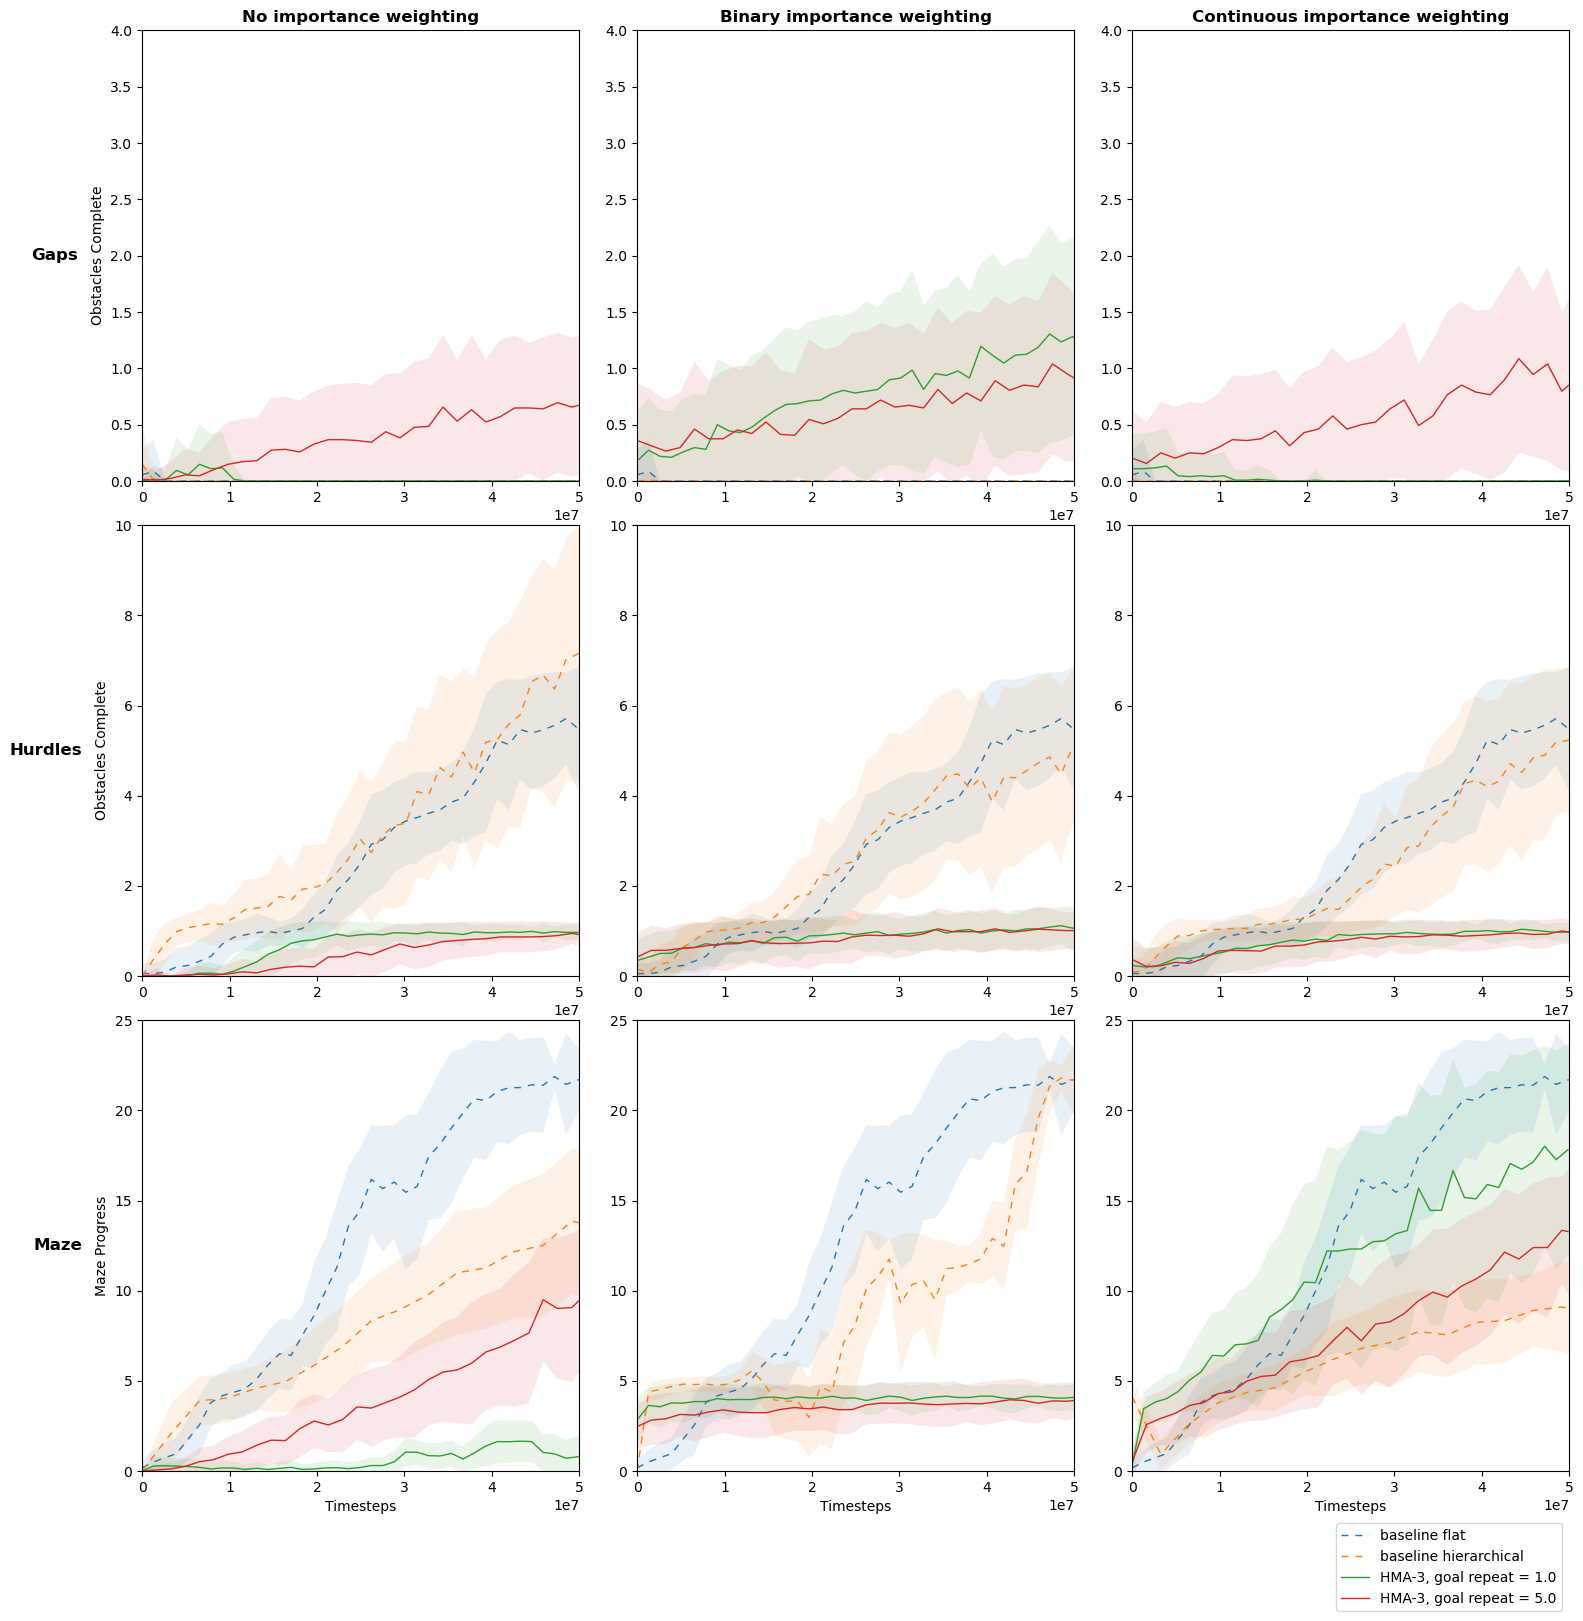

In [ ]:


goal_importance_vals = [None, 'discrete', 'continuous']
action_repeats = [1.0, 5.0]
reward_types = ['sparse']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

plt.tight_layout()

for k, environment in enumerate(benchmark_task_data['environment'].unique()):

    if environment == 'maze':
        metric = 'eval/episode_distance_to_end'
        ylim = (0, 25)  
        ylabel = 'Maze Progress'
    else:
        metric = 'eval/episode_obstacles_complete'
        ylabel = 'Obstacles Complete'
        if environment == 'gaps':
            ylim = (0, 4)
        else:
            ylim = (0, 10)

    #metric = 'eval/episode_reward'

    for i, reward_type in enumerate(reward_types):
        
        df = get_benchmark_data(environment, reward_type, True)
        df = df[df.model != 'hma2'] 
        df['plot_data'] = df['modelpath'].apply(lambda x: get_training_metrics(x))

        flat = baseline[(baseline.model == 'flat') & (baseline.environment == environment)]
        hier = baseline[(baseline.model == 'hma2') & (baseline.environment == environment)]
        hma2 = df[(df.model == 'hma3') & (df.no_root_goals == False) & (df.low_level_goal_repeat == 1.0)]

        for j, goal_importance in enumerate(goal_importance_vals):

            if goal_importance is None:
                t = 'No importance weighting'
            elif goal_importance == 'discrete':
                t = 'Binary importance weighting'
            else:
                t = 'Continuous importance weighting'
            ax = axs[k, j]
            ax.set_title(t if k==0 else None, weight='bold')

            if j == 0:
                ax.annotate(environment.capitalize(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation='horizontal', weight='bold')

            if pd.isna(goal_importance):
                ax_data = hma2[hma2.goal_importance.isna()]
                hier_data = hier[hier.goal_importance.isna()]
            else:
                ax_data = hma2[hma2.goal_importance == goal_importance]
                hier_data = hier[hier.goal_importance == goal_importance]
                        
            plot(
                data=flat.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline flat", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = (0,10),
                ax = ax,
                linestyle= '--'
                )
            
            plot(
                data=hier_data.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline hierarchical", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = (0,10),
                ax = ax,
                linestyle= '--'
                )
            
            for action_repeat in action_repeats:
                try:
                    plot_data = ax_data[ax_data.action_repeat == action_repeat]['plot_data'].iloc[0]
                except:
                    continue

                plot(
                    data=plot_data, 
                    metric=metric, 
                    error='std', 
                    label=f"HMA-3, goal repeat = {action_repeat}", 
                    err_label = None, 
                    xlabel = 'Timesteps' if k==2 else None, 
                    ylabel = ylabel if j==0 else None,
                    xlim = (0, 50_000_000),
                    ylim = ylim,
                    ax = ax
                    )
                
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.1))
plt.savefig('hma3.png')



## Low level discrete analysis

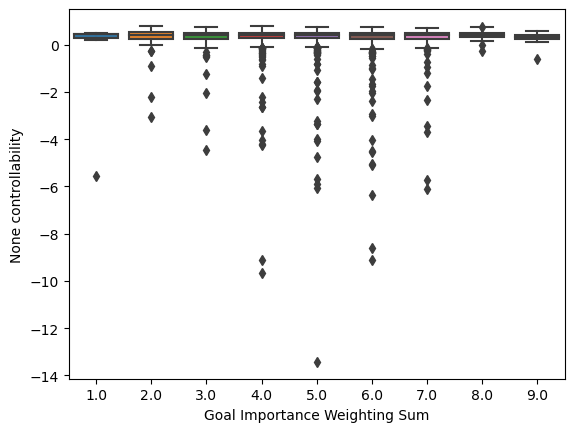

Text(0.5, 1.0, 'Lower limb nodes')

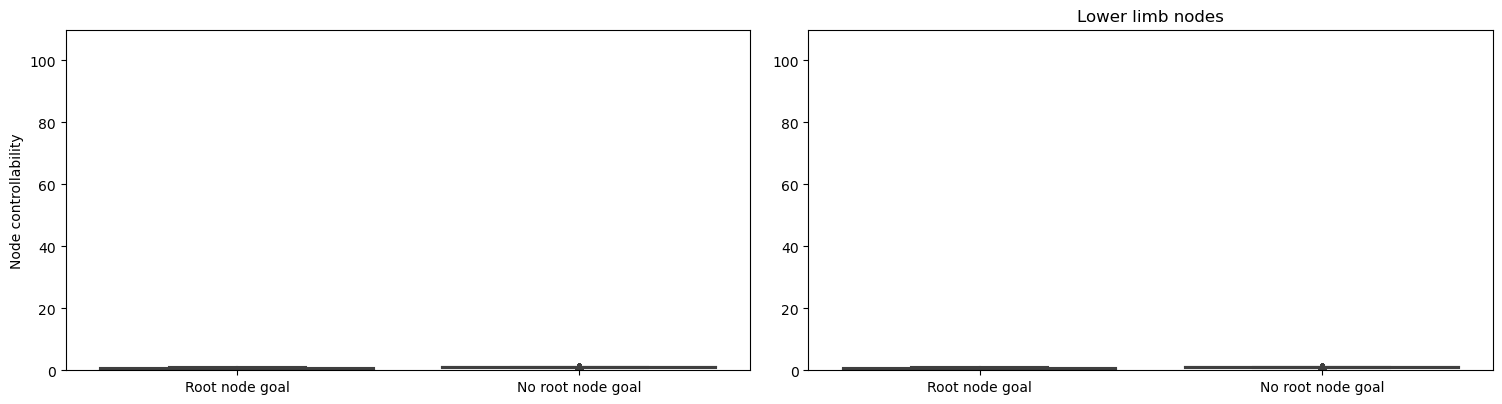

In [21]:
from hct.envs.tools import node_dist, world_to_relative, world_to_egocentric
from brax import base
import numpy as np


modelpath = Path(f"{hma_filepath}/low_level/runs/2")

def analyse_skills(modelpath):
    env = load(f"{modelpath}/env")
    exp_data = load(f"{modelpath}/data")
    data = exp_data['data']

    states = data.nstate
    if hasattr(env, 'low_level_env'):
        vmap_rel = jax.vmap(jax.vmap(world_to_egocentric))
        vmap_abstract = jax.vmap(jax.vmap(env.abstract_state))
        relative_states = vmap_abstract(vmap_rel(states.pipeline_state))
    else:
        vmap_rel = jax.vmap(jax.vmap(world_to_relative, in_axes=(0, None)), in_axes=(0, None))
        x, xd = vmap_rel(states.pipeline_state, env)
        relative_states = states.pipeline_state.replace(x=x, xd=xd)
    goals = states.info['goal']
    goal_count = states.info['goal_count']
    importance = goals.importance

    node_dist_in_axes = (None, 0, 0, 0, 0, None, None, 0)
    node_dist_vmap = jax.vmap(jax.vmap(node_dist, in_axes=node_dist_in_axes), in_axes=node_dist_in_axes)
    node_goal_dist = node_dist_vmap(
        env, 
        relative_states.x,
        relative_states.xd,
        goals.x_rel,
        goals.xd_rel,
        False,
        False,
        importance
    )               
    
    def first_last_indices_values(A, B):
        A = A.flatten()
        B = B.reshape(-1, B.shape[-1])
        
        mask = jp.concatenate((jp.array([True]), A[1:] != A[:-1])) | jp.concatenate((A[:-1] != A[1:], jp.array([True])))
        # find the indices of True values
        true_indices = jp.where(mask)[0]

        # find the differences between consecutive True indices
        diffs = jp.diff(true_indices)

        # find the start and end indices of consecutive True sequences
        start_indices = jp.where(diffs != 1)[0] + 1
        end_indices = jp.where(diffs != 1)[0]

        # add the start and end indices of the array
        start_indices = jp.insert(start_indices, 0, 0)
        end_indices = jp.append(end_indices, len(true_indices) - 1)

        # set the middle True values to False
        for start, end in zip(start_indices, end_indices):
            if end - start >= 2:
                middle_indices = true_indices[start:end + 1][1:-1]
                mask = mask.at[middle_indices].set(False)


        result = B[mask]
        return result.reshape(-1, 2, B.shape[-1])
    

    
    dist_changes = first_last_indices_values(goal_count, node_goal_dist)
    importance_per_goal = first_last_indices_values(goal_count, importance.squeeze())[:, 0, :]
    importance_norm_per_goal = first_last_indices_values(goal_count, jp.linalg.norm(importance.squeeze(), axis=2, keepdims=True))[:, 0, :]
    control = (1 - (dist_changes[:, 1, :]/((dist_changes[:, 0, :]) + 1e-10)))

    return {
        'dist_changes': dist_changes,
        'importance': importance_per_goal, 
        'importance_norm_per_goal': importance_norm_per_goal.squeeze(), 
        'control': control}

out = analyse_skills(modelpath)
#print([i.shape for i in out])



# root goals

root_goal_indices = jp.argwhere(out['importance'][:, 0]==1.0).squeeze()
x = jp.round(out['importance_norm_per_goal'][root_goal_indices] ** 2) 
y = out['control'][root_goal_indices, 0]
sns.boxplot(x=np.asarray(x), y=np.asarray(y))
plt.xlabel('Goal Importance Weighting Sum')
plt.ylabel('None controllability')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
plt.tight_layout()

# upper limb goals
ax = axs[0]
idx = range(1, 9)
x = jp.tile(out['importance_norm_per_goal'], len(idx))
control = jp.concatenate([out['control'][:, i] for i in idx])
dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))

goal_indices_root = jp.argwhere((importance==1.0) * (importance_root==1.0)).squeeze()
goal_indices_no_root = jp.argwhere((importance==1.0) * (importance_root==0.0)).squeeze()

x = jp.round(x[goal_indices_root] ** 2) 
y = control[goal_indices_root]
data = [control[goal_indices_root], control[goal_indices_no_root]]

sns.boxplot(data=data, ax=ax)
ax.set_ylabel('Node controllability')
ax.set_xticks(ticks=[0, 1], labels=['Root node goal', 'No root node goal'])
ax.set_ylim(0, 110)

# lower limb goals
ax = axs[1]

idx = [2,4,6,8]
#idx = [2,4,6,8]
x = jp.tile(out['importance_norm_per_goal'], len(idx))
control = jp.concatenate([out['control'][:, i] for i in idx])
dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))


goal_indices_root = jp.argwhere((importance==1.0) * (importance_root==1.0)).squeeze()
goal_indices_no_root = jp.argwhere((importance==1.0) * (importance_root==0.0)).squeeze()

x = jp.round(x[goal_indices_root] ** 2) 
y = control[goal_indices_root]
data = [control[goal_indices_root], control[goal_indices_no_root]]
'''
unique_x= jp.unique(x)
means = jp.array([jp.mean(y[jp.where(x==ux)]) for ux in unique_x])
stds = jp.array([jp.std(y[jp.where(x==ux)]) for ux in unique_x])
stderrs = stds / jp.sqrt(jp.array([len(y[jp.where(x==ux)]) for ux in unique_x]))'''


sns.boxplot(data, ax=ax)
ax.set_ylabel(None)
ax.set_xticks(ticks=[0, 1], labels=['Root node goal', 'No root node goal'])
ax.set_ylim(0, 110)
ax.set_title('Lower limb nodes')



#plt.scatter(jp.repeat(out['importance_norm_per_goal'], 4), jp.concatenate([out['control'][:, 2], out['control'][:, 4], out['control'][:, 6], out['control'][:, 8]] ), s=1)





(-0.25, 1.0)

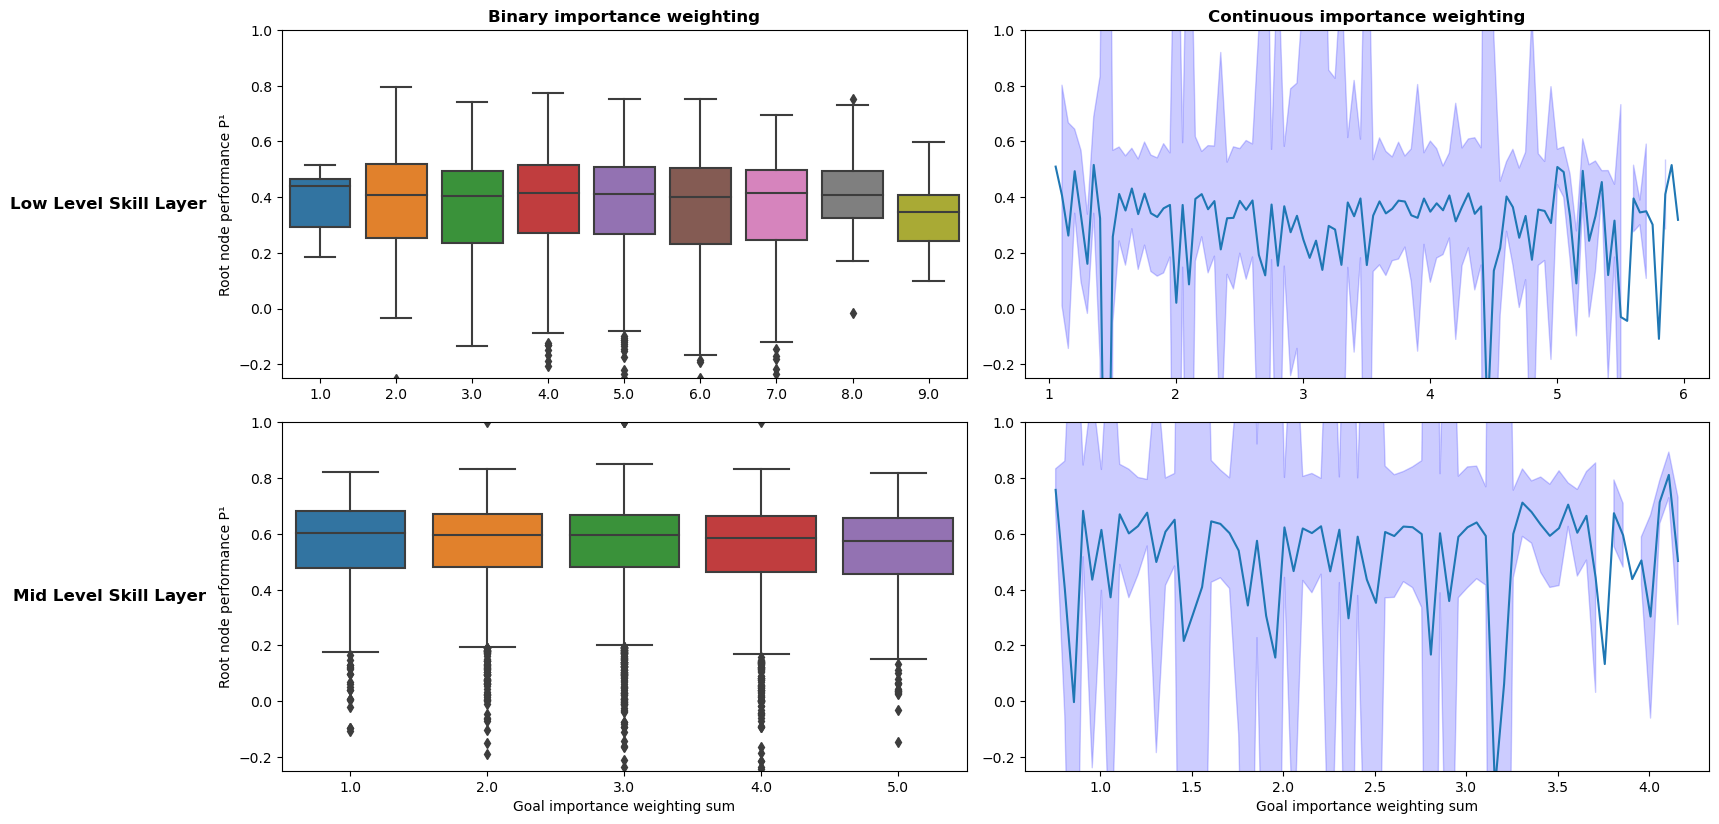

In [37]:
hyperparam_sweeps = hyperparam_sweeps_v2
hma_filepath = hyperparam_sweeps / "hma"
hurdles_filepath = hyperparam_sweeps / "hurdles"
gaps_filepath = hyperparam_sweeps / "gaps"
maze_filepath = hyperparam_sweeps / "maze"

fig, axs = plt.subplots(2,2, figsize=(15, 8))
plt.tight_layout()
#print([i.shape for i in out])


# low level discrete 
ax = axs[0, 0]
modelpath = Path(f"{hma_filepath}/low_level/runs/2")
out = analyse_skills(modelpath)
root_goal_indices = jp.argwhere(out['importance'][:, 0]==1.0).squeeze()
x = jp.round(out['importance_norm_per_goal'][root_goal_indices] ** 2) 
y = out['control'][root_goal_indices, 0]
sns.boxplot(x=np.asarray(x), y=np.asarray(y), ax=ax)
ax.set_xlabel(None)
ax.set_ylabel('Root node performance P¹')
ax.set_title("Binary importance weighting", weight='bold')
ax.annotate('Low Level Skill Layer', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
    xycoords=ax.yaxis.label, textcoords='offset points',
    size='large', ha='right', va='center', rotation='horizontal', weight='bold')
ax.set_ylim(-0.25, 1)


# mid level discrete
ax = axs[1, 0]
modelpath = Path(f"{hma_filepath}/mid_level/runs/8")
out = analyse_skills(modelpath)
root_goal_indices = jp.argwhere(out['importance'][:, 0]==1.0).squeeze()
x = jp.round(out['importance_norm_per_goal'][root_goal_indices] ** 2) 
y = out['control'][root_goal_indices, 0]
sns.boxplot(x=np.asarray(x), y=np.asarray(y), ax=ax)
ax.set_xlabel('Goal importance weighting sum')
ax.set_ylabel('Root node performance P¹')
ax.annotate('Mid Level Skill Layer', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
    xycoords=ax.yaxis.label, textcoords='offset points',
    size='large', ha='right', va='center', rotation='horizontal', weight='bold')
ax.set_ylim(-0.25, 1)


#low level continuous
ax = axs[0, 1]
modelpath = Path(f"{hma_filepath}/low_level/runs/1")
out = analyse_skills(modelpath)
root_goal_indices = jp.argwhere(out['importance'][:, 0] > 0.8).squeeze()

x = out['importance_norm_per_goal'][root_goal_indices]  ** 2
y = out['control'][root_goal_indices, 0] / out['importance'][root_goal_indices, 0]

bins = jp.arange(jp.min(x), jp.max(x)+0.01, 0.05)
plotdata = pd.DataFrame({'x': x, 'y': y})
plotdata['x_bin'] = np.digitize(plotdata['x'], bins)
mean_y_per_bin = plotdata.groupby('x_bin')['y'].mean()
std_y_per_bin = plotdata.groupby('x_bin')['y'].std()
x = np.asarray(bins)
y = np.asarray(mean_y_per_bin.to_numpy())

sns.lineplot(x=x[:len(y)], y=y, ax=ax)
ax.fill_between(x[:len(y)], y - std_y_per_bin, y + std_y_per_bin, color='b', alpha=0.2)
ax.set_ylim(-0.25, 1)
ax.set_title("Continuous importance weighting", weight='bold')

#low level continuous
ax = axs[1, 1]
modelpath = Path(f"{hma_filepath}/mid_level/runs/4")
out = analyse_skills(modelpath)
root_goal_indices = jp.argwhere(out['importance'][:, 0] > 0.8).squeeze()

x = out['importance_norm_per_goal'][root_goal_indices]  ** 2
y = out['control'][root_goal_indices, 0] / out['importance'][root_goal_indices, 0]

bins = jp.arange(jp.min(x), jp.max(x)+0.01, 0.05)
plotdata = pd.DataFrame({'x': x, 'y': y})
plotdata['x_bin'] = np.digitize(plotdata['x'], bins)
mean_y_per_bin = plotdata.groupby('x_bin')['y'].mean()
std_y_per_bin = plotdata.groupby('x_bin')['y'].std()
x = np.asarray(bins)
y = np.asarray(mean_y_per_bin.to_numpy())

sns.lineplot(x=x[:len(y)], y=y, ax=ax)
ax.fill_between(x[:len(y)], y - std_y_per_bin, y + std_y_per_bin, color='b', alpha=0.2)

ax.set_xlabel('Goal importance weighting sum')
ax.set_ylim(-0.25, 1)


(-4.0, 1.0)

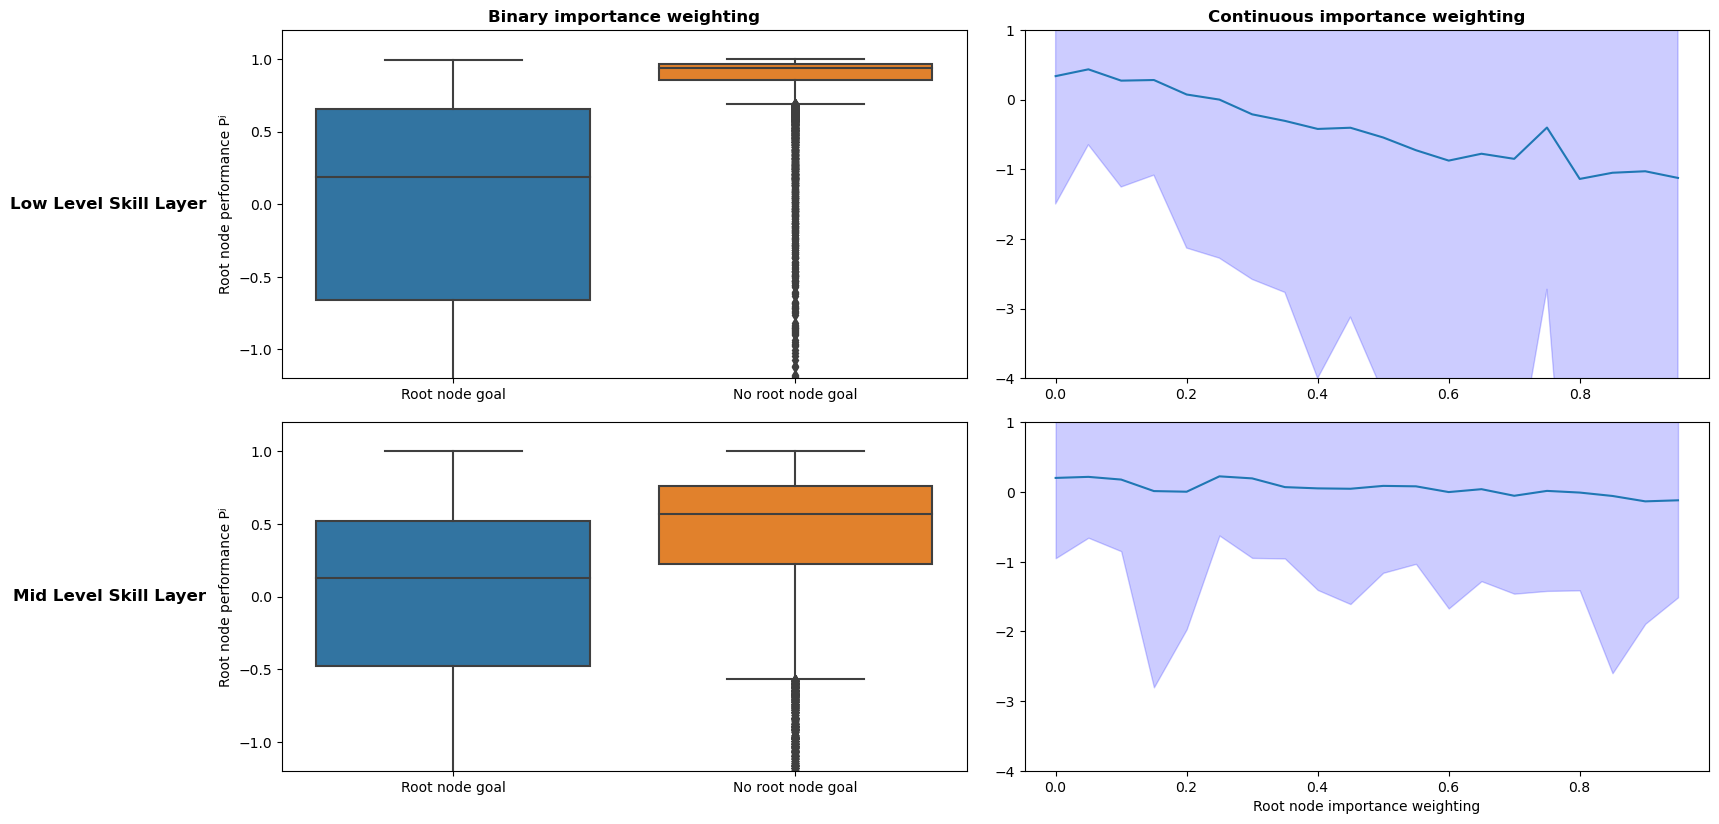

In [36]:
fig, axs = plt.subplots(2,2, figsize=(15, 8))
plt.tight_layout()
#print([i.shape for i in out])


# low level discrete 
ax = axs[0, 0]
modelpath = Path(f"{hma_filepath}/low_level/runs/2")
out = analyse_skills(modelpath)

idx = range(1, 9)
x = jp.tile(out['importance_norm_per_goal'], len(idx))
control = jp.concatenate([out['control'][:, i] for i in idx])
dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))

goal_indices_root = jp.argwhere((importance==1.0) * (importance_root==1.0)).squeeze()
goal_indices_no_root = jp.argwhere((importance==1.0) * (importance_root==0.0)).squeeze()

x = jp.round(x[goal_indices_root] ** 2) 
y = control[goal_indices_root]
data = [control[goal_indices_root], control[goal_indices_no_root]]

sns.boxplot(data=data, ax=ax)
ax.set_ylabel('Root node performance Pʲ')
ax.set_xticks(ticks=[0, 1], labels=['Root node goal', 'No root node goal'])

ax.set_ylim(-1.2, 1.2)
ax.set_title("Binary importance weighting", weight='bold')
ax.annotate('Low Level Skill Layer', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
    xycoords=ax.yaxis.label, textcoords='offset points',
    size='large', ha='right', va='center', rotation='horizontal', weight='bold')


# mid level discrete
ax = axs[1, 0]
modelpath = Path(f"{hma_filepath}/mid_level/runs/8")
out = analyse_skills(modelpath)

idx = range(1, 9)
x = jp.tile(out['importance_norm_per_goal'], len(idx))
control = jp.concatenate([out['control'][:, i] for i in idx])
dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))

goal_indices_root = jp.argwhere((importance==1.0) * (importance_root==1.0)).squeeze()
goal_indices_no_root = jp.argwhere((importance==1.0) * (importance_root==0.0)).squeeze()

x = jp.round(x[goal_indices_root] ** 2) 
y = control[goal_indices_root]
data = [control[goal_indices_root], control[goal_indices_no_root]]


sns.boxplot(data=data, ax=ax)
ax.set_ylabel('Root node performance Pʲ')
ax.set_xticks(ticks=[0, 1], labels=['Root node goal', 'No root node goal'])
ax.set_ylim(-1.2, 1.2)

ax.annotate('Mid Level Skill Layer', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
    xycoords=ax.yaxis.label, textcoords='offset points',
    size='large', ha='right', va='center', rotation='horizontal', weight='bold')


#low level continuous
ax = axs[0, 1]
modelpath = Path(f"{hma_filepath}/low_level/runs/1")
out = analyse_skills(modelpath)
idx = range(1, 9)
x = jp.tile(out['importance_norm_per_goal'] ** 2, len(idx)) 
control = jp.concatenate([out['control'][:, i] for i in idx]) 
dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))

ind = jp.argwhere((jp.abs(importance).squeeze()) >0.9)

x = jp.abs(importance_root[ind]).squeeze()
y = (control[ind] / importance[ind]).squeeze()


bins = jp.arange(jp.min(x), jp.max(x)+0.01, 0.05)
plotdata = pd.DataFrame({'x': x, 'y': y})
plotdata['x_bin'] = np.digitize(plotdata['x'], bins)
mean_y_per_bin = plotdata.groupby('x_bin')['y'].mean()
std_y_per_bin = plotdata.groupby('x_bin')['y'].std()
x = np.asarray(bins)
y = np.asarray(mean_y_per_bin.to_numpy())

sns.lineplot(x=x[:len(y)], y=y, ax=ax)
ax.fill_between(x[:len(y)], y - std_y_per_bin, y + std_y_per_bin, color='b', alpha=0.2)

ax.set_ylim(-4, 1)
ax.set_title("Continuous importance weighting", weight='bold')

#mid level continuous
ax = axs[1, 1]
modelpath = Path(f"{hma_filepath}/mid_level/runs/4")
out = analyse_skills(modelpath)
idx = range(1, 5)

x = jp.tile(out['importance_norm_per_goal'] ** 2, len(idx)) ** 2
control = jp.concatenate([out['control'][:, i] for i in idx]) 

dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))

ind = jp.argwhere((jp.abs(importance).squeeze()) >0.8)

x = jp.abs(importance_root[ind]).squeeze()
y = (control[ind] / importance[ind]).squeeze()

bins = jp.arange(jp.min(x), jp.max(x)+0.01, 0.05)
plotdata = pd.DataFrame({'x': x, 'y': y})
plotdata['x_bin'] = np.digitize(plotdata['x'], bins)
mean_y_per_bin = plotdata.groupby('x_bin')['y'].mean()
std_y_per_bin = plotdata.groupby('x_bin')['y'].std()
x = np.asarray(bins)
y = np.asarray(mean_y_per_bin.to_numpy())

sns.lineplot(x=x[:len(y)], y=y, ax=ax)
ax.fill_between(x[:len(y)], y - std_y_per_bin, y + std_y_per_bin, color='b', alpha=0.2)

ax.set_xlabel('Root node importance weighting')
ax.set_ylim(-4, 1)


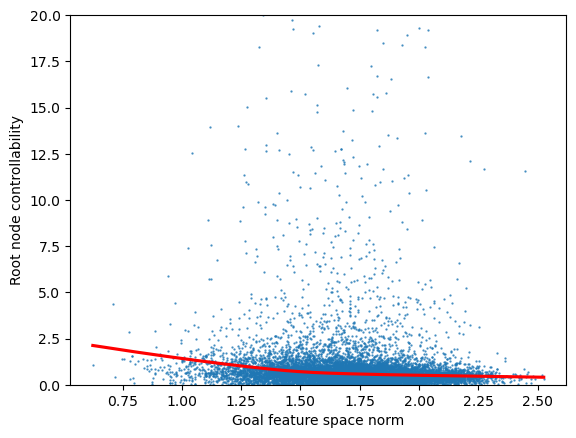

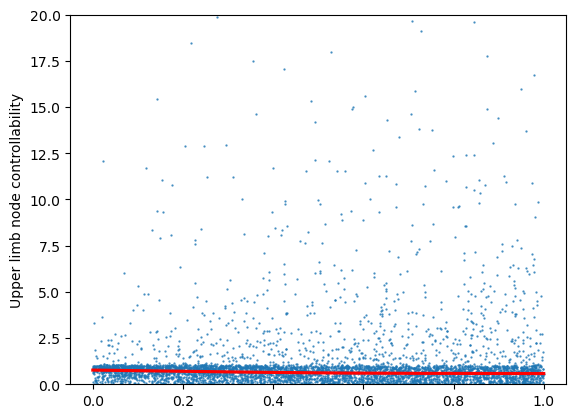

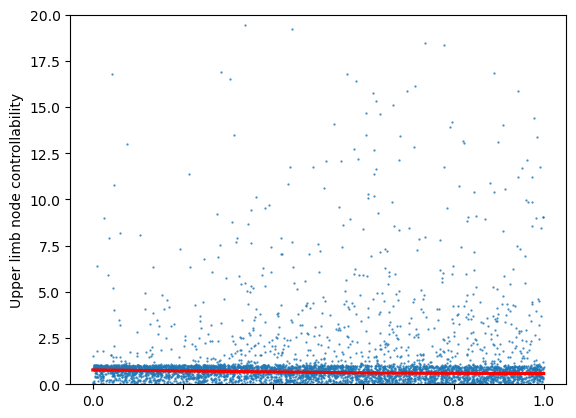

In [19]:
from hct.envs.tools import node_dist, world_to_relative, world_to_egocentric
from brax import base
import numpy as np


modelpath = Path(f"{hma_filepath}/low_level/runs/1")


out = analyse_skills(modelpath)
#print([i.shape for i in out])

# root goals
root_goal_indices = jp.argwhere(out['importance'][:, 0] > 0).squeeze()
x = out['importance_norm_per_goal'][root_goal_indices]
y = out['control'][root_goal_indices, 0] / out['importance'][:, 0]
sns.regplot(x=x, y=y, lowess=True, line_kws={'color': 'red'}, scatter_kws={'s': 0.4})
plt.xlabel('Goal feature space norm')
plt.ylabel('Root node controllability')
plt.ylim(0, 20)
plt.show()


# upper_limb goals
idx = [1,3,5,7]
#idx = [2,4,6,8]
x = jp.tile(out['importance_norm_per_goal'], len(idx))
control = jp.concatenate([out['control'][:, i] for i in idx]) 
dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))

ind = jp.argwhere((jp.abs(importance).squeeze()) >0.9)

x = jp.abs(importance_root[ind])
y = control[ind] / importance[ind]


sns.regplot(x=x, y=y, lowess=True, line_kws={'color': 'red'}, scatter_kws={'s': 0.4})
plt.ylabel('Upper limb node controllability')

plt.ylim(0, 20)
plt.show()

# lower_limb goals
#idx = [1,3,5,7]
idx = [2,4,6,8]
x = jp.tile(out['importance_norm_per_goal'], len(idx))
control = jp.concatenate([out['control'][:, i] for i in idx])
dist_changes = jp.concatenate([out['dist_changes'][:, :, i] for i in idx])

importance = jp.concatenate([out['importance'][:, i] for i in idx])
importance_root = jp.tile(out['importance'][:, 0], len(idx))

ind = jp.argwhere((jp.abs(importance).squeeze()) >0.9)

x = jp.abs(importance_root[ind])
y = control[ind] / importance[ind]


sns.regplot(x=x, y=y, lowess=True, line_kws={'color': 'red'}, scatter_kws={'s': 0.4})
plt.ylabel('Upper limb node controllability')

plt.ylim(0, 20)
plt.show()


AttributeError: 'HMA2HurdlesGapsEnv' object has no attribute 'no_root_goals'

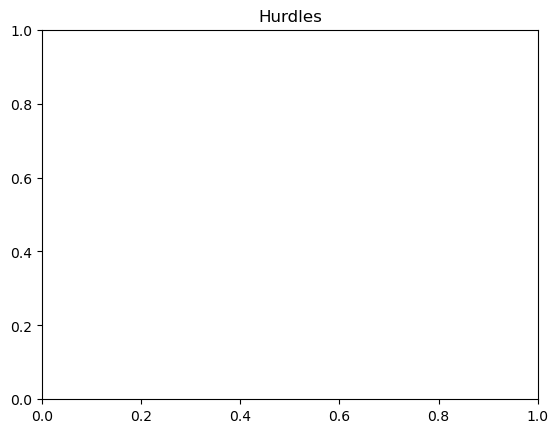

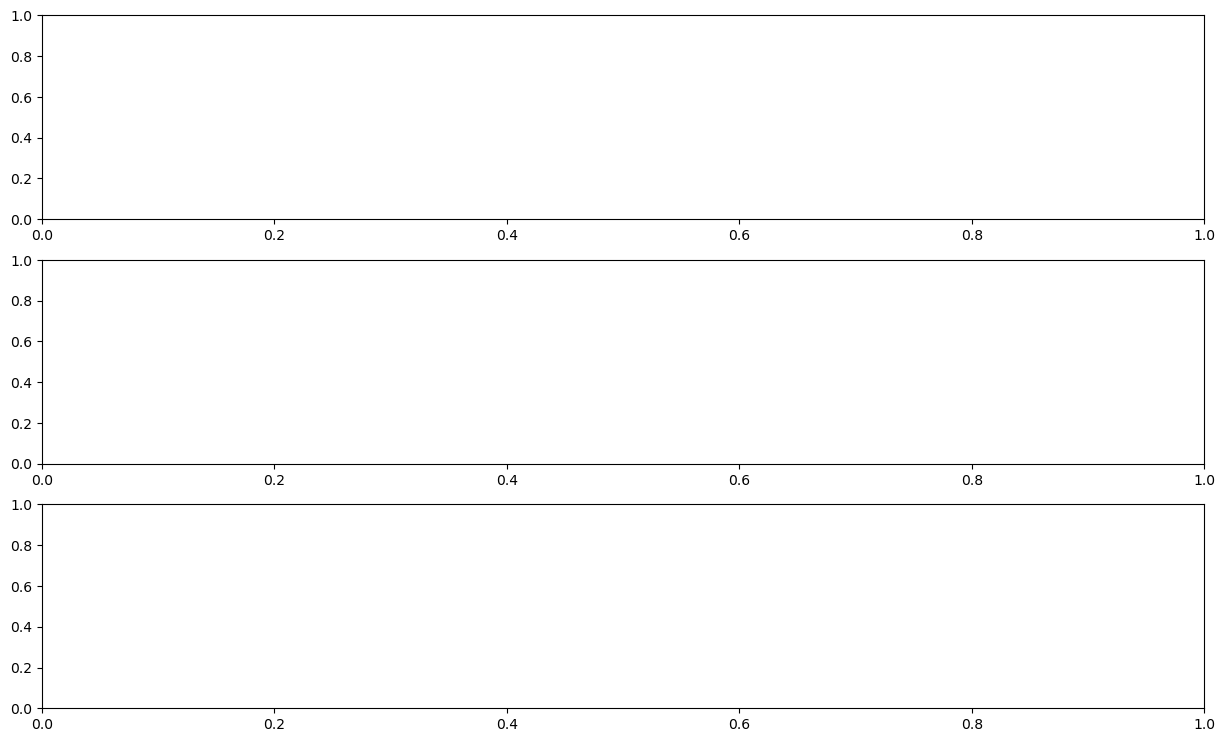

In [20]:
def analyse_hurdlesgaps(modelpath):
    fig, axs = plt.subplots(3,1, figsize=(15,9))
    env = load(f"{modelpath}/env")
    exp_data = load(f"{modelpath}/data")
    data = exp_data['data']

    task = modelpath.parent.parent.parent.name
    
    obstacle_sizes = [0.24, 0.23, 0.22, 0.34, 0.24, 0.34, 0.23, 0.24, 0.39, 0.38, 0.29, 0.39, 0.39, 0.36, 0.3, 0.36, 0.34, 0.3, 0.36, 0.31]
    obstacle_coords = [2.48, 4.74, 7.08, 9.2, 11.68, 14.44, 16.54, 18.4, 20.76, 23.58, 26.26, 28.44, 31.26, 33.28, 35.92, 38.56, 40.56, 43.06, 45.42, 47.96]

    if task == 'maze':
        obstacle_coords = np.arange(0, 23)
        lim = 22
    else:
        obstacle_coords = jp.array(obstacle_coords) - jp.array(obstacle_sizes)
        lim = 45

    def plot(idx, ax):
        if task == 'hurdles':
            y_sizes = obstacle_sizes[0::2]
            obstacle_completion_coords = obstacle_coords[0::2]
            
        states = data.nstate

        actions = data.action
        
        importance = jax.vmap(jax.vmap(env.get_low_level_goal))(actions, states.pipeline_state).importance
        importance = importance.reshape(-1, *importance.shape[2:]).squeeze()[:, idx]

        if type(idx) is list:
            importance = jp.mean(importance, axis=-1)

        if task == 'maze':
            yvals = states.metrics['distance_to_end']
            yvals = 22 - yvals.flatten()
            bins = jp.arange(0, 23)
        else:
            yvals = states.pipeline_state.x.pos[..., 0, 1]
            yvals = yvals.reshape(-1, *yvals.shape[2:])
            bins = jp.arange(0, jp.max(yvals)+0.3, 0.3)

        x = yvals
        y = importance
        plotdata = pd.DataFrame({'x': x, 'y': y})


        plotdata['x_bin'] = np.digitize(plotdata['x'], bins)
        mean_y_per_bin = plotdata.groupby('x_bin')['y'].mean()

        x = np.asarray(bins)
        y = np.asarray(mean_y_per_bin.to_numpy())

        if type(idx) is not list:
            c = 'C0'
        elif idx[0] == 1:
            c = 'C1'
        else:
            c = 'C2'

        sns.lineplot(x=x[:len(y)], y=y, ax=ax, color=c)
        for i in obstacle_coords:
            ax.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
    
        ax.set_ylim(0, 1)
        ax.set_xlim(0, lim)


    plot(0, axs[0])
    plot([1,3,5,7], axs[1])
    plot([2,4,6,8], axs[2])



    
    plt.show()

plt.title('Hurdles')
modelpath = Path(f"{hurdles_filepath}/hma2/runs/32")
analyse_hurdlesgaps(modelpath)

modelpath = Path(f"{hurdles_filepath}/hma2/runs/16")
analyse_hurdlesgaps(modelpath)

modelpath = Path(f"{gaps_filepath}/hma2/runs/32")
analyse_hurdlesgaps(modelpath)

modelpath = Path(f"{gaps_filepath}/hma2/runs/16")
analyse_hurdlesgaps(modelpath)

modelpath = Path(f"{maze_filepath}/hma2/runs/32")
analyse_hurdlesgaps(modelpath)

modelpath = Path(f"{maze_filepath}/hma2/runs/16")
analyse_hurdlesgaps(modelpath)

In [ ]:
data = generate_data_tables(hyperparam_sweeps_v3)
benchmark_task_data = data[(data.environment == 'gaps') | (data.environment == 'hurdles') | (data.environment == 'maze')].sort_values(by="model_variant_id")
baseline = pd.concat([data[(data.model == 'flat') & (data.reward_type == 'sparse')], data2[(data2.model == 'hma2') & (data2.reward_type == 'sparse') & (data2.action_repeat == 1.0)]])
baseline['plot_data'] = baseline['modelpath'].apply(lambda x: get_training_metrics(x))
def get_benchmark_data(environment,  reward_type, task_information, sortby='eval/episode_obstacles_complete', ascending=False):
    if sortby == 'eval/episode_obstacles_complete' and environment == 'maze':
        sortby = 'eval/episode_distance_to_end'
        ascending = True
    elif sortby == 'eval/episode_distance_to_end' and environment != 'maze':
        sortby = 'eval/episode_obstacles_complete'
        ascending = False
    df = benchmark_task_data[(benchmark_task_data.environment == environment) & (benchmark_task_data.reward_type == reward_type) & (benchmark_task_data.task_information == task_information)].sort_values(sortby, ascending=ascending)
    return df
a = get_benchmark_data('maze', 'dense', True, 'action_repeat')
a[a.model == 'hma2'].head(50)


,date,model,environment,model_variant_id,modelpath,position_goals,velocity_goals,goal_dist,distance_reward,goal_importance,eval/walltime,training/sps,training/walltime,training/entropy_loss,training/policy_loss,training/total_loss,training/v_loss,eval/episode_cumulative_final_goal_dist,eval/episode_cumulative_return,eval/episode_goal_dist,eval/episode_goals_reached,eval/episode_is_unhealthy,eval/episode_reward,eval/episode_weight,eval/avg_episode_length,eval/epoch_eval_time,eval/sps,state_below,low_level_modelpath,action_repeat,no_root_goals,low_level_goal_repeat,reward_type,task_information,eval/episode_obstacles_complete,eval/episode_task_complete,reward_movement,state,mid_level_modelpath,mid_level_goal_repeat,eval/episode_distance_to_end,eval/episode_maze_column,eval/episode_maze_row
97,08/31 21:43:15.846383,hma2,maze,1,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,None,420.275768,30959.568746,1620.311514,-0.23517275,-0.0032236055,5821.5312,5821.7695,NaN,NaN,NaN,NaN,0.2422 ± 0.4284,1102.4451 ± 217.5640,NaN,1300.7422 ± 298.7409,12.757638,15049.808398,True,0.0,5.0,NaN,5.0,dense,True,NaN,0.3828 ± 0.4861,velocity,NaN,NaN,NaN,2.5859 ± 4.1317,1.4766 ± 0.8288,2.0156 ± 1.1179
101,08/31 22:29:45.614199,hma2,maze,5,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,continuous,416.749981,30898.200874,1621.705974,-0.3748517,-0.009211972,2338.2544,2338.6387,NaN,NaN,NaN,NaN,0.1250 ± 0.3307,648.8408 ± 98.0409,NaN,1388.7109 ± 318.9425,13.199398,14546.118417,True,1.0,5.0,NaN,5.0,dense,True,NaN,0.0000 ± 0.0000,velocity,NaN,NaN,NaN,10.1562 ± 2.0480,3.2188 ± 0.4667,4.1719 ± 0.8848
105,09/01 22:28:57.436899,hma2,maze,9,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,discrete,350.516713,24897.569646,2012.292911,-0.32174164,0.0031124572,6052.969,6053.2876,NaN,NaN,NaN,NaN,0.1875 ± 0.3903,1130.5405 ± 240.8946,NaN,1221.2891 ± 341.5814,10.403116,18456.008356,True,2.0,5.0,NaN,5.0,dense,True,NaN,0.5938 ± 0.4911,velocity,NaN,NaN,NaN,2.1328 ± 4.4902,1.3828 ± 0.9364,1.6406 ± 1.0057
96,08/31 21:23:22.167049,hma2,maze,0,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,None,558.515859,25663.955638,1972.099095,-0.33664376,-0.00396576,235.87933,236.21994,NaN,NaN,NaN,NaN,0.0000 ± 0.0000,1236.5723 ± 28.3176,NaN,613.5938 ± 31.9598,13.969202,13744.521658,True,0.0,1.0,NaN,1.0,dense,True,NaN,1.0000 ± 0.0000,velocity,NaN,NaN,NaN,0.0000 ± 0.0000,1.0000 ± 0.0000,1.0000 ± 0.0000
100,08/31 22:21:20.154160,hma2,maze,4,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,continuous,556.612096,25573.086286,1985.966097,-0.36538514,-0.0058110654,328.76886,329.14008,NaN,NaN,NaN,NaN,0.0469 ± 0.2114,1049.9604 ± 137.2335,NaN,1402.5000 ± 223.3468,13.711814,14002.523251,True,1.0,1.0,NaN,1.0,dense,True,NaN,0.1953 ± 0.3964,velocity,NaN,NaN,NaN,2.0625 ± 2.8000,1.7734 ± 0.5033,1.8203 ± 0.4749
104,09/01 22:28:57.437546,hma2,maze,8,/nfs/nhome/live/aoomerjee/MSc-Thesis/hct/train...,True,None,relative,relative,discrete,539.923275,21699.864841,2326.992051,-0.39686877,0.00013092461,347.48654,347.8833,NaN,NaN,NaN,NaN,0.0000 ± 0.0000,1232.9629 ± 28.5058,NaN,605.8281 ± 35.0237,13.081959,14676.700398,True,2.0,1.0,NaN,1.0,dense,True,NaN,1.0000 ± 0.0000,velocity,NaN,NaN,NaN,0.0000 ± 0.0000,1.0000 ± 0.0000,1.0000 ± 0.0000


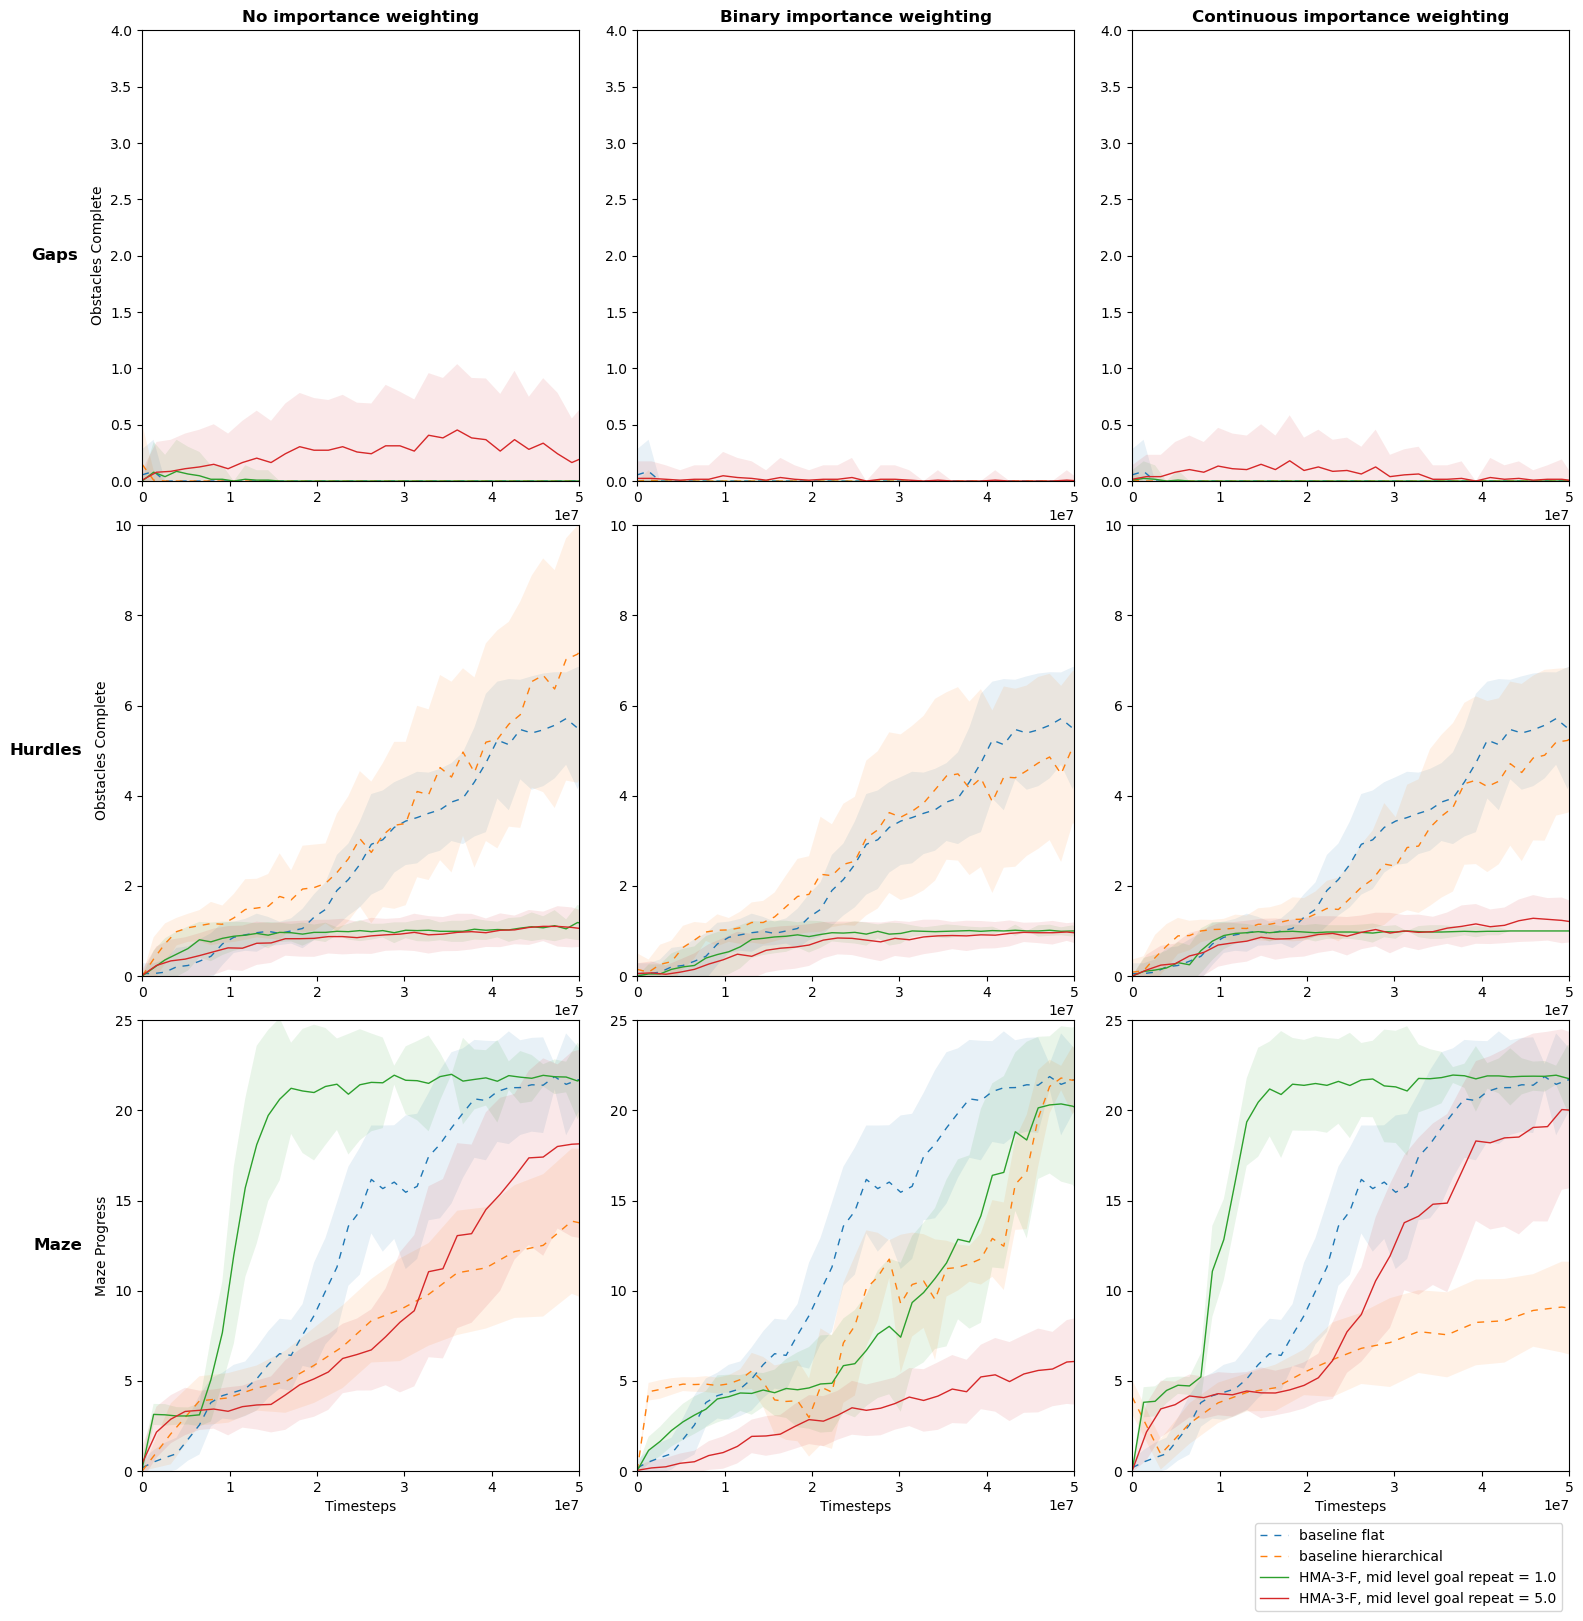

In [ ]:
goal_importance_vals = [None, 'discrete', 'continuous']
action_repeats = [1.0, 5.0]
reward_types = ['sparse']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

plt.tight_layout()

for k, environment in enumerate(benchmark_task_data['environment'].unique()):

    if environment == 'maze':
        metric = 'eval/episode_distance_to_end'
        ylim = (0, 25)  
        ylabel = 'Maze Progress'
    else:
        metric = 'eval/episode_obstacles_complete'
        ylabel = 'Obstacles Complete'
        if environment == 'gaps':
            ylim = (0, 4)
        else:
            ylim = (0, 10)

    #metric = 'eval/episode_reward'

    for i, reward_type in enumerate(reward_types):
        
        df = get_benchmark_data(environment, reward_type, True)
        df = df[df.model != 'hma2'] 
        df['plot_data'] = df['modelpath'].apply(lambda x: get_training_metrics(x))

        flat = baseline[(baseline.model == 'flat') & (baseline.environment == environment)]
        hier = baseline[(baseline.model == 'hma2') & (baseline.environment == environment)]
        hma2 = df[(df.model == 'hma3') & (df.no_root_goals == False) & (df.low_level_goal_repeat == 1.0) & (df.state == 'below') & (df.goal_dist == 'relative')]


        for j, goal_importance in enumerate(goal_importance_vals):

            if goal_importance is None:
                t = 'No importance weighting'
            elif goal_importance == 'discrete':
                t = 'Binary importance weighting'
            else:
                t = 'Continuous importance weighting'
            ax = axs[k, j]
            ax.set_title(t if k==0 else None, weight='bold')

            if j == 0:
                ax.annotate(environment.capitalize(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation='horizontal', weight='bold')

            if pd.isna(goal_importance):
                ax_data = hma2[hma2.goal_importance.isna()]
                hier_data = hier[hier.goal_importance.isna()]
            else:
                ax_data = hma2[hma2.goal_importance == goal_importance]
                hier_data = hier[hier.goal_importance == goal_importance]
                        
            plot(
                data=flat.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline flat", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = (0,10),
                ax = ax,
                linestyle= '--'
                )
            
            plot(
                data=hier_data.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline hierarchical", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = (0,10),
                ax = ax,
                linestyle= '--'
                )
            
            for action_repeat in action_repeats:
                try:
                    plot_data = ax_data[ax_data.action_repeat == action_repeat]['plot_data'].iloc[0]
                except:
                    continue

                plot(
                    data=plot_data, 
                    metric=metric, 
                    error='std', 
                    label=f"HMA-3-F, mid level goal repeat = {action_repeat}", 
                    err_label = None, 
                    xlabel = 'Timesteps' if k==2 else None, 
                    ylabel = ylabel if j==0 else None,
                    xlim = (0, 50_000_000),
                    ylim = ylim,
                    ax = ax
                    )
                
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.1))



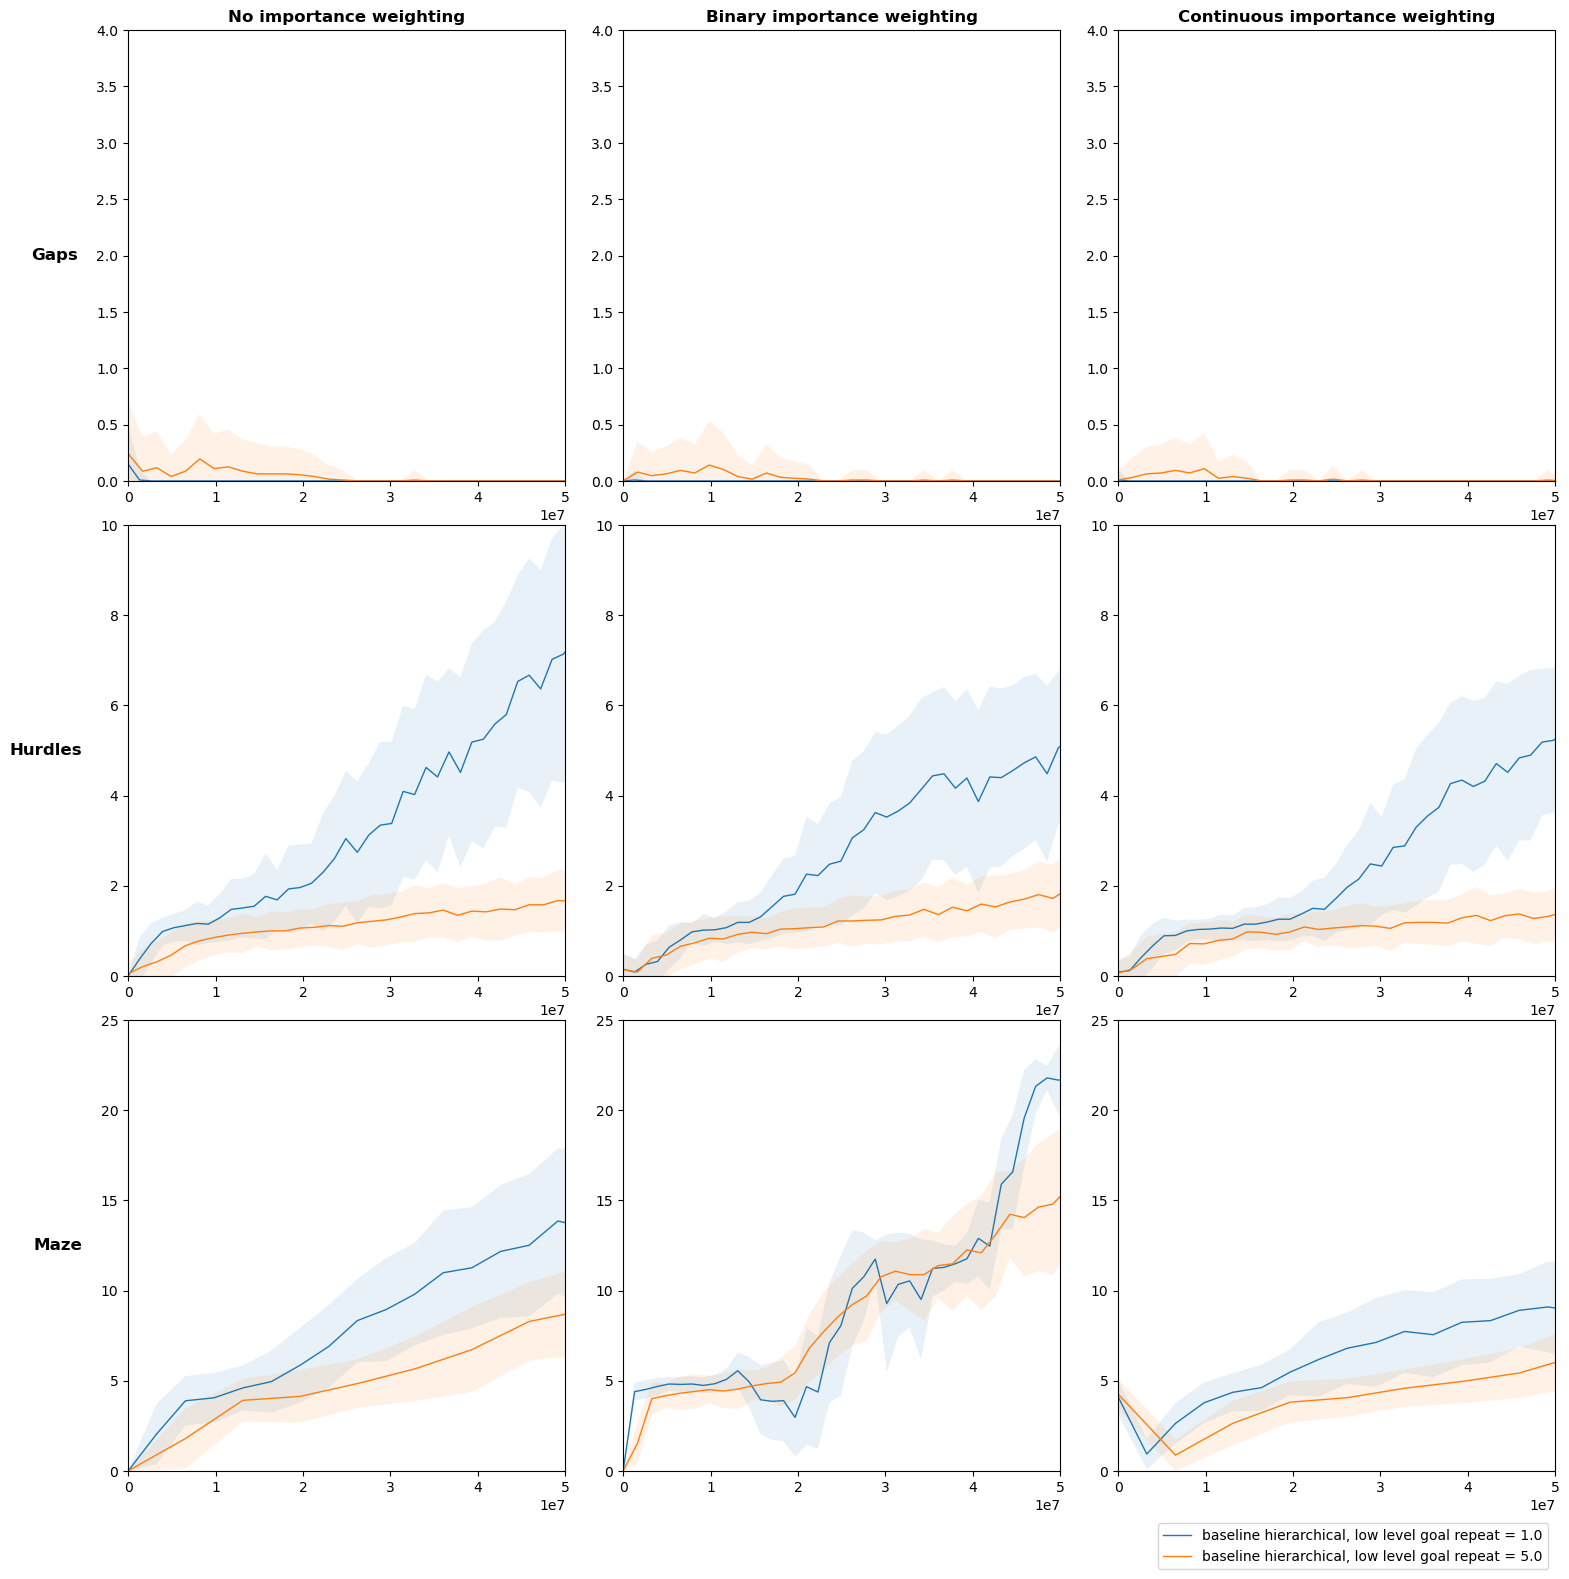

In [ ]:
goal_importance_vals = [None, 'discrete', 'continuous']
action_repeats = [1.0, 5.0]
reward_types = ['sparse']
baseline = pd.concat([data[(data.model == 'flat') & (data.reward_type == 'sparse')], data2[(data2.model == 'hma2') & (data2.reward_type == 'sparse')]])
baseline['plot_data'] = baseline['modelpath'].apply(lambda x: get_training_metrics(x))
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

plt.tight_layout()

for k, environment in enumerate(benchmark_task_data['environment'].unique()):

    if environment == 'maze':
        metric = 'eval/episode_distance_to_end'
        ylim = (0, 25)  
        ylabel = 'Maze Progress'
    else:
        metric = 'eval/episode_obstacles_complete'
        ylabel = 'Obstacles Complete'
        if environment == 'gaps':
            ylim = (0, 4)
        else:
            ylim = (0, 10)

    #metric = 'eval/episode_reward'

    for i, reward_type in enumerate(reward_types):
        
        df = get_benchmark_data(environment, reward_type, True)
        df = df[df.model != 'hma2'] 
        df['plot_data'] = df['modelpath'].apply(lambda x: get_training_metrics(x))

        flat = baseline[(baseline.model == 'flat') & (baseline.environment == environment)]
        hier = baseline[(baseline.model == 'hma2') & (baseline.environment == environment) & (baseline.action_repeat == 1.0)]
        hier2 = baseline[(baseline.model == 'hma2') & (baseline.environment == environment) & (baseline.action_repeat != 1.0)]
        hma2 = df[(df.model == 'hma3') & (df.no_root_goals == False) & (df.low_level_goal_repeat == 1.0) & (df.state == 'below') & (df.goal_dist == 'absolute')]


        for j, goal_importance in enumerate(goal_importance_vals):

            if goal_importance is None:
                t = 'No importance weighting'
            elif goal_importance == 'discrete':
                t = 'Binary importance weighting'
            else:
                t = 'Continuous importance weighting'
            ax = axs[k, j]
            ax.set_title(t if k==0 else None, weight='bold')

            if j == 0:
                ax.annotate(environment.capitalize(), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation='horizontal', weight='bold')

            if pd.isna(goal_importance):
                ax_data = hma2[hma2.goal_importance.isna()]
                hier_data = hier[hier.goal_importance.isna()]
                hier_data2 = hier2[hier2.goal_importance.isna()]
            else:
                ax_data = hma2[hma2.goal_importance == goal_importance]
                hier_data = hier[hier.goal_importance == goal_importance]
                hier_data2 = hier2[hier2.goal_importance == goal_importance]
                        


            
            plot(
                data=hier_data.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline hierarchical, low level goal repeat = 1.0", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = (0,10),
                ax = ax,
                linestyle= '-'
                )
            
            plot(
                data=hier_data2.plot_data.iloc[0], 
                metric=metric, 
                error='std', 
                label=f"baseline hierarchical, low level goal repeat = 5.0", 
                err_label = None, 
                xlabel = None, 
                ylabel = None,
                xlim = (0, 50_000_000),
                ylim = ylim,
                ax = ax,
                linestyle= '-'
                )
            

plt.legend(loc='upper right', bbox_to_anchor=(1, -0.1))